# Analysis of AWS pings

## Process to generate input file

Generate file pingWithoutQuotes.txt by running the following commands:

`mysql -u -p -h aws-index.ckidp9rjzhn2.eu-west-1.rds.amazonaws.com aws_index -e "select * from ping" | sed 's/\t/","/g;s/^/"/;s/$/"/;s/\n//g' > ping.txt`

`sed 's/"//g' ping.txt > pingWithoutQuotes.txt`




## Configuration

In [1]:
import numpy as np
import pandas as pd
from scipy import constants
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Using matplotlib backend: Qt5Agg


In [2]:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 300

In [3]:
def valuesGreaterThanPercentile95(group,q95):
    outliers = group[group['latency'] > q95]
    return outliers.index

def removeLatencyGreaterThanP95AtGroupLevel(df):
    dfGrouped = df.groupby(['origin','destination'])
    q95 = dfGrouped.quantile(.95)
    df95 = df.copy(deep=True)
    for (name,group) in dfGrouped:
        df95.drop(valuesGreaterThanPercentile95(group,q95.loc[name].values[0]), inplace=True)
    return df95

def groupLatencyHist(group, color=None):
    n, bins, patches = plt.hist(group['latency'], bins='auto', histtype='bar', color=color)
    idx = list(n).index(max(n))
    return max(n),bins[idx],bins[idx+1]
    

## Read file

Read file into a dataframe.

**Note**: latency is expressed in seconds

In [4]:
raw_df = pd.read_table('pingWithoutQuotes-march.txt', sep='\t', index_col=0, skiprows=0, parse_dates=[4])
raw_df.rename(columns={"des,ina,ion":"destination","la,ency":"latency","crea,ed_a,":"created_at","upda,ed_a,":"updated_at"}, inplace=True)
raw_df = raw_df.drop(columns='updated_at')
raw_df.head()

,origin,destination,latency,created_at
id,,,,
1,ireland,ireland,0.020900,2019-02-23 20:44:49
2,ireland,oregon,0.279399,2019-02-23 20:44:49
3,ireland,saopaulo,0.389177,2019-02-23 20:44:49
4,ireland,sydney,0.553866,2019-02-23 20:44:49
5,oregon,oregon,0.009678,2019-02-23 20:44:52


Quick look at resulting dataframe

In [5]:
print(raw_df.shape)
print(raw_df.columns)
print(raw_df.index)

(819755, 4)
Index(['origin', 'destination', 'latency', 'created_at'], dtype='object')
Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            819746, 819747, 819748, 819749, 819750, 819751, 819752, 819753,
            819754, 819755],
           dtype='int64', name='id', length=819755)


Removing same origin-destination records

In [6]:
df = raw_df.drop(index = raw_df[raw_df['origin'] == raw_df['destination']].index)
df.head()

,origin,destination,latency,created_at
id,,,,
2,ireland,oregon,0.279399,2019-02-23 20:44:49
3,ireland,saopaulo,0.389177,2019-02-23 20:44:49
4,ireland,sydney,0.553866,2019-02-23 20:44:49
6,oregon,ireland,0.274449,2019-02-23 20:44:52
7,oregon,sydney,0.284749,2019-02-23 20:44:52


In [7]:
#Checkpoint: number of elemenets on df after removing same origin-destination rows is the one expected
print(raw_df.shape[0]*3/4 == df.shape[0])
print("\n======================================================================================================")
print(f"After cleaning up, we have a dataframe with {df.shape[0]} rows and {df.shape[1]} columns")
print("======================================================================================================")

False

After cleaning up, we have a dataframe with 614816 rows and 4 columns



===============================================================
============================================================

## Data analysis

Study of the latency between different regions

In [8]:
dfGrouped = df.groupby(['origin','destination'])
dfGrouped.mean().sort_values('latency')

latency
origin   destination          
ireland  oregon       0.268155
oregon   ireland      0.268327
sydney   oregon       0.279346
oregon   sydney       0.279721
saopaulo oregon       0.367777
oregon   saopaulo     0.368061
saopaulo ireland      0.368807
ireland  saopaulo     0.369214
         sydney       0.536720
sydney   ireland      0.536844
         saopaulo     0.631353
saopaulo sydney       0.632153

In [9]:
statistics_df = dfGrouped.describe(percentiles=[.05, .25, .75, .95])
statistics_df

latency                                          \
                        count      mean       std       min        5%   
origin   destination                                                    
ireland  oregon       51234.0  0.268155  0.040775  0.245196  0.258758   
         saopaulo     51234.0  0.369214  0.040817  0.347545  0.359614   
         sydney       51234.0  0.536720  0.016977  0.510826  0.525650   
oregon   ireland      51234.0  0.268327  0.024441  0.245088  0.258900   
         saopaulo     51234.0  0.368061  0.046118  0.352109  0.359477   
         sydney       51234.0  0.279721  0.022737  0.277190  0.277989   
saopaulo ireland      51236.0  0.368807  0.017236  0.347567  0.359656   
         oregon       51235.0  0.367777  0.037393  0.351766  0.359324   
         sydney       51236.0  0.632153  0.141693  0.616597  0.626235   
sydney   ireland      51235.0  0.536844  0.051841  0.510875  0.525309   
         oregon       51235.0  0.279346  0.012523  0.277111  0.277921   
         saopaulo     51235.0  0.631353  0.032709  0.616816  0.626108   

                                                                         
                           25%       50%       75%       95%        max  
origin   destination                                                     
ireland  oregon       0.265501  0.267597  0.270096  0.274195   7.285261  
         saopaulo     0.367988  0.369254  0.370245  0.371546   6.629116  
         sydney       0.530772  0.539511  0.539847  0.540535   2.970800  
oregon   ireland      0.265778  0.268059  0.270451  0.274600   3.391192  
         saopaulo     0.363625  0.367035  0.369526  0.372662   4.966958  
         sydney       0.278365  0.278598  0.278916  0.280191   3.294457  
saopaulo ireland      0.368034  0.369295  0.370296  0.371565   1.508819  
         oregon       0.363492  0.366836  0.369346  0.372274   3.368329  
         sydney       0.629358  0.630523  0.631510  0.632952  31.846530  
sydney   ireland      0.530799  0.539532  0.539882  0.540525  11.926738  
         oregon       0.278287  0.278508  0.278762  0.279454   1.278411  
         saopaulo     0.629220  0.630388  0.631390  0.632871   5.040968

The maximum values are way too high compared to their respective median (percentile 50). To avoid having these outliers affect the overall statistics, we will remove all the values above percentile 95

### Latency after removing outliers

In [10]:
df95 = removeLatencyGreaterThanP95AtGroupLevel(df)
df95Grouped = df95.groupby(['origin','destination'])
df95Grouped.mean().sort_values('latency')

,,latency
origin,destination,
ireland,oregon,0.267159
oregon,ireland,0.267397
sydney,oregon,0.278496
oregon,sydney,0.278629
saopaulo,oregon,0.365982
oregon,saopaulo,0.366153
ireland,saopaulo,0.367805
saopaulo,ireland,0.367862
ireland,sydney,0.536054


Latency results are roughly the same in both directions for all pairs origin-destination

In [11]:
statistics_df95 = df95Grouped.describe(percentiles=[.05, .25, .75, .95])
statistics_df95[('latency','width')] = statistics_df95[('latency','max')] - statistics_df95[('latency','min')]
statistics_df95

latency                                          \
                        count      mean       std       min        5%   
origin   destination                                                    
ireland  oregon       48672.0  0.267159  0.004295  0.245196  0.258713   
         saopaulo     48672.0  0.367805  0.003912  0.347545  0.359557   
         sydney       48672.0  0.536054  0.005264  0.510826  0.524677   
oregon   ireland      48672.0  0.267397  0.004360  0.245088  0.258829   
         saopaulo     48672.0  0.366153  0.003840  0.352109  0.359344   
         sydney       48672.0  0.278629  0.000445  0.277190  0.277977   
saopaulo ireland      48674.0  0.367862  0.003909  0.347567  0.359608   
         oregon       48673.0  0.365982  0.003801  0.351766  0.359176   
         sydney       48674.0  0.630039  0.001980  0.616597  0.626126   
sydney   ireland      48673.0  0.536064  0.005271  0.510875  0.524705   
         oregon       48673.0  0.278496  0.000353  0.277111  0.277911   
         saopaulo     48673.0  0.629908  0.001998  0.616816  0.625998   

                                                                        \
                           25%       50%       75%       95%       max   
origin   destination                                                     
ireland  oregon       0.264760  0.267363  0.269902  0.273689  0.274195   
         saopaulo     0.367843  0.369170  0.370063  0.371086  0.371545   
         sydney       0.530605  0.539468  0.539794  0.540200  0.540535   
oregon   ireland      0.265099  0.267668  0.270142  0.273911  0.274600   
         saopaulo     0.363435  0.366731  0.369151  0.371406  0.372662   
         sydney       0.278351  0.278575  0.278850  0.279502  0.280191   
saopaulo ireland      0.367901  0.369214  0.370119  0.371138  0.371565   
         oregon       0.363309  0.366540  0.368974  0.371097  0.372273   
         sydney       0.629257  0.630445  0.631334  0.632440  0.632952   
sydney   ireland      0.530641  0.539479  0.539829  0.540228  0.540525   
         oregon       0.278274  0.278488  0.278709  0.279119  0.279454   
         saopaulo     0.629109  0.630311  0.631203  0.632340  0.632871   

                                
                         width  
origin   destination            
ireland  oregon       0.028999  
         saopaulo     0.024000  
         sydney       0.029709  
oregon   ireland      0.029512  
         saopaulo     0.020553  
         sydney       0.003001  
saopaulo ireland      0.023998  
         oregon       0.020507  
         sydney       0.016355  
sydney   ireland      0.029650  
         oregon       0.002343  
         saopaulo     0.016056

**Check to make sure that df95 was calculated correctly:**
given that df95 is the result of keeping 95% of the values of df, the following must be true:

In [12]:
dfCount = df.shape[0]
df95Count = df95.shape[0] 
np.round(df95Count/dfCount,2) == 0.95

True

## Histograms

### Ireland

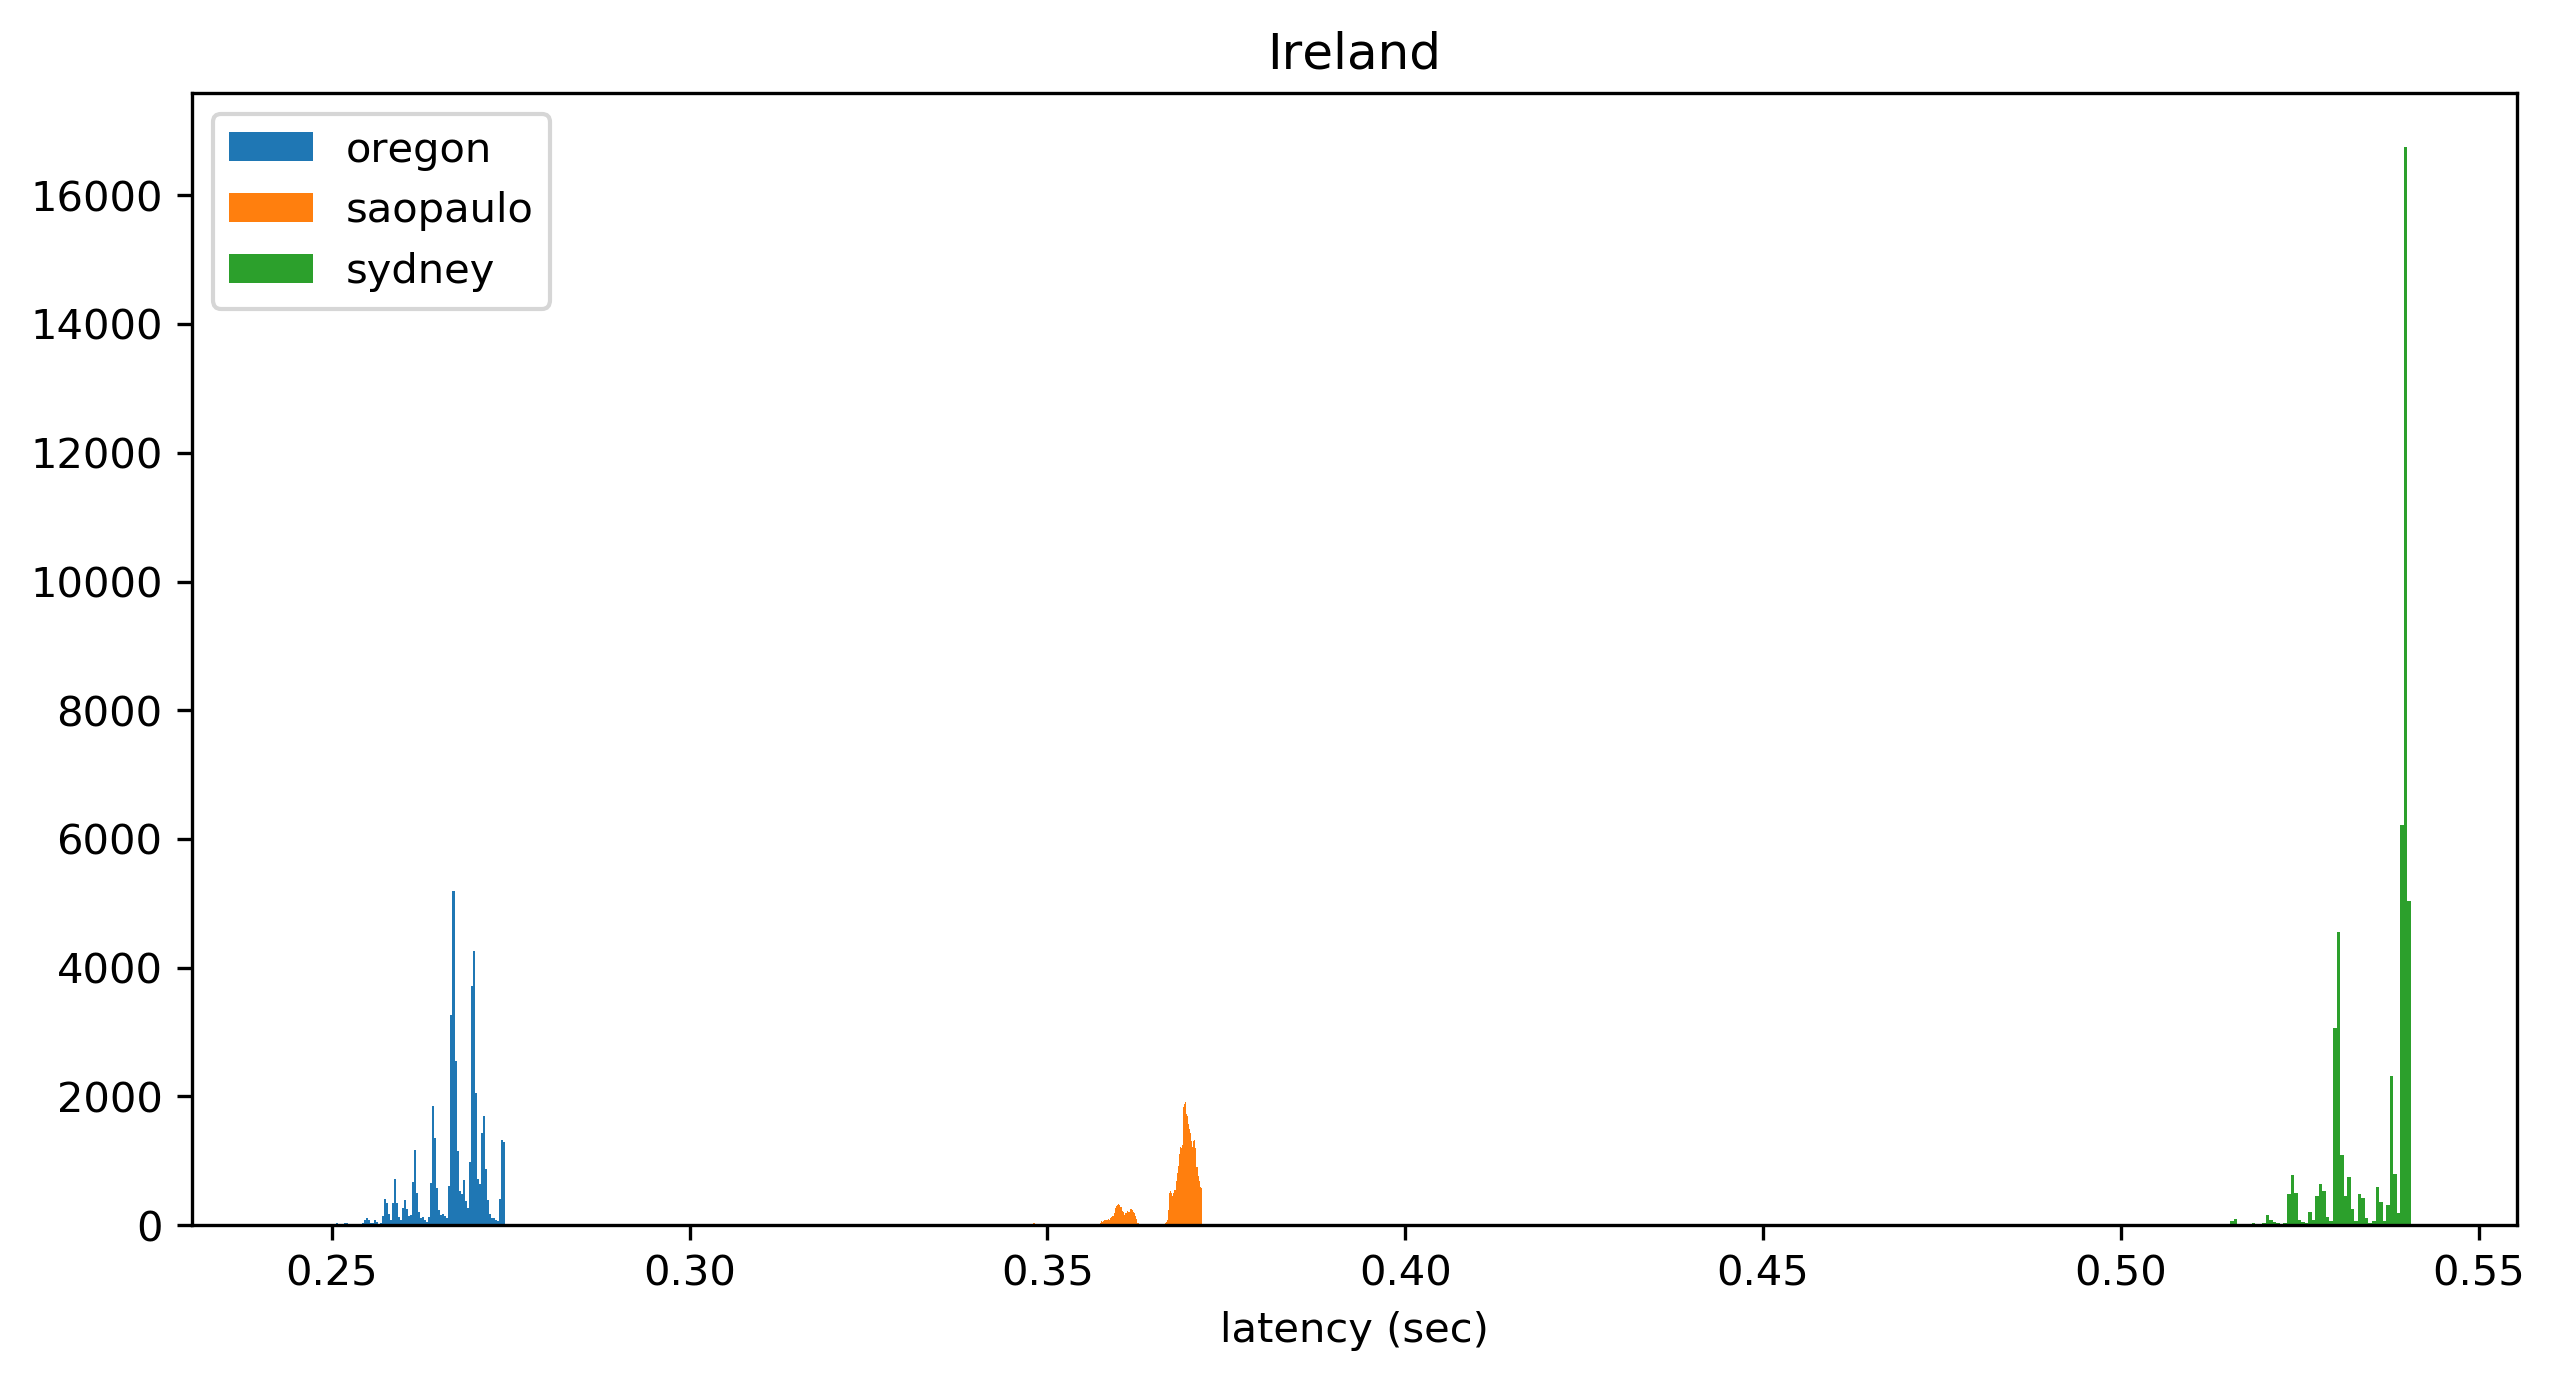

In [38]:
plt.hist(df95Grouped.get_group(('ireland','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('ireland','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.hist(df95Grouped.get_group(('ireland','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.title("Ireland")
plt.xlabel('latency (sec)')
plt.legend()
plt.savefig("ireland-march.png")

### Oregon

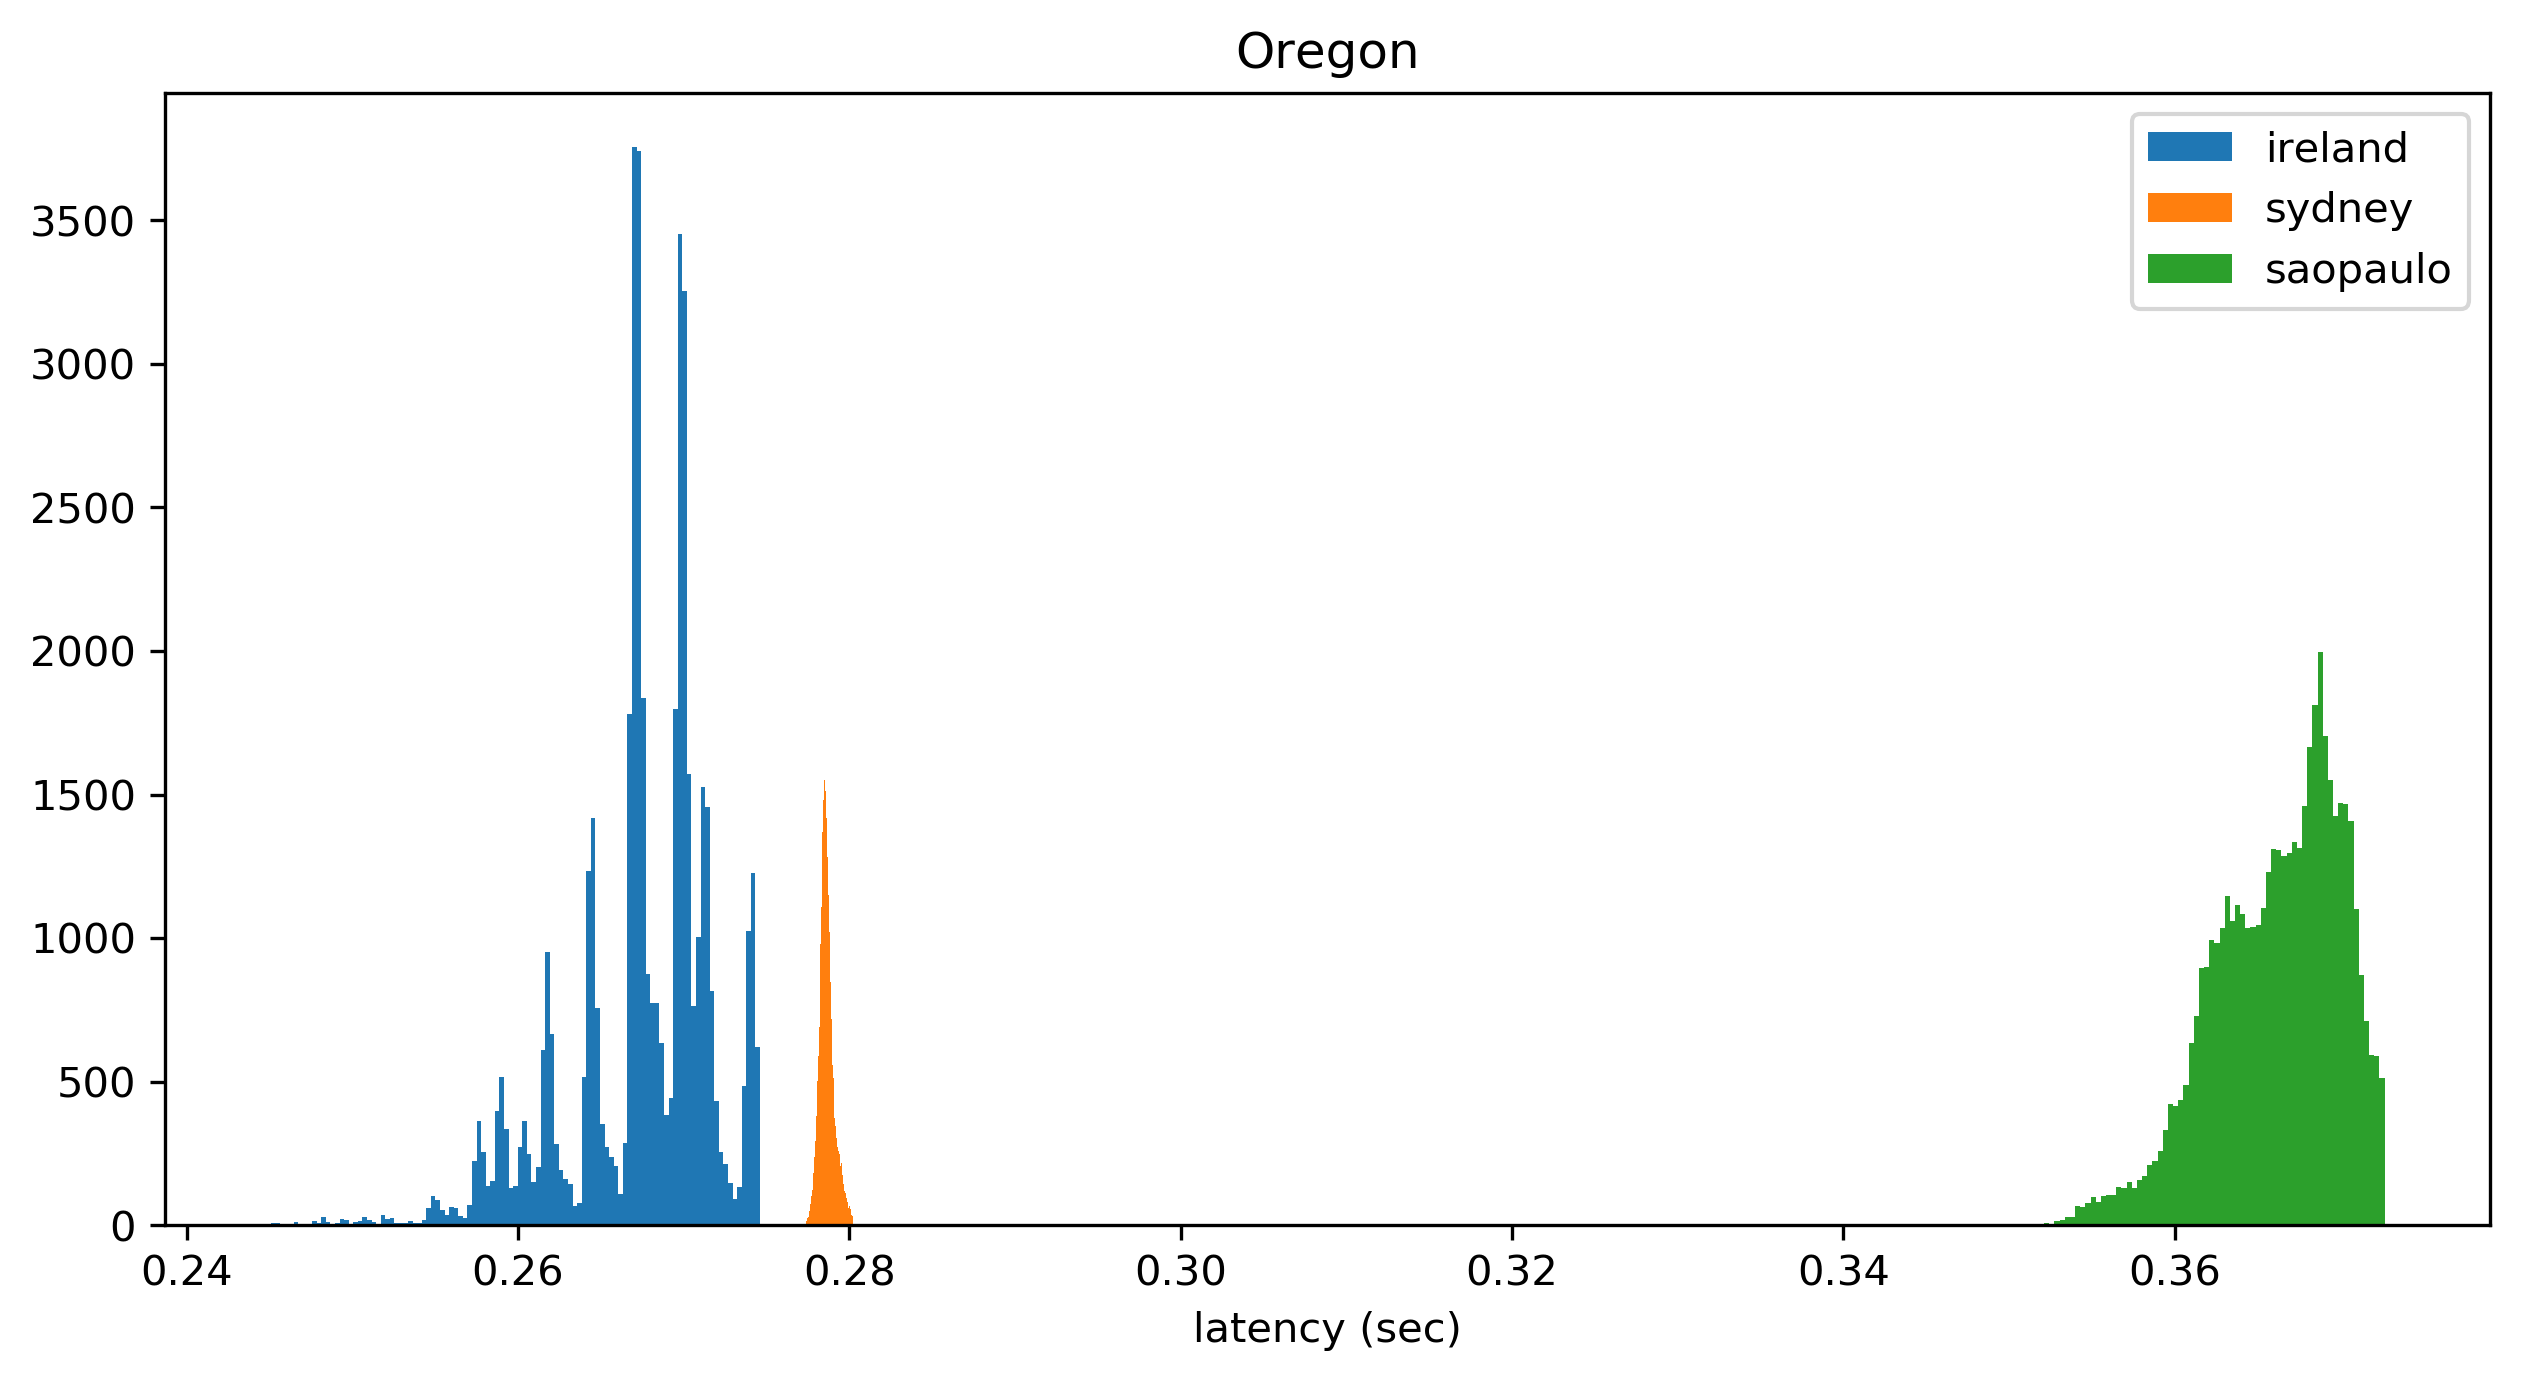

In [37]:
plt.hist(df95Grouped.get_group(('oregon','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('oregon','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.hist(df95Grouped.get_group(('oregon','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.title("Oregon")
plt.xlabel('latency (sec)')
plt.legend()
plt.savefig("oregon-march.png")

### Sao Paulo

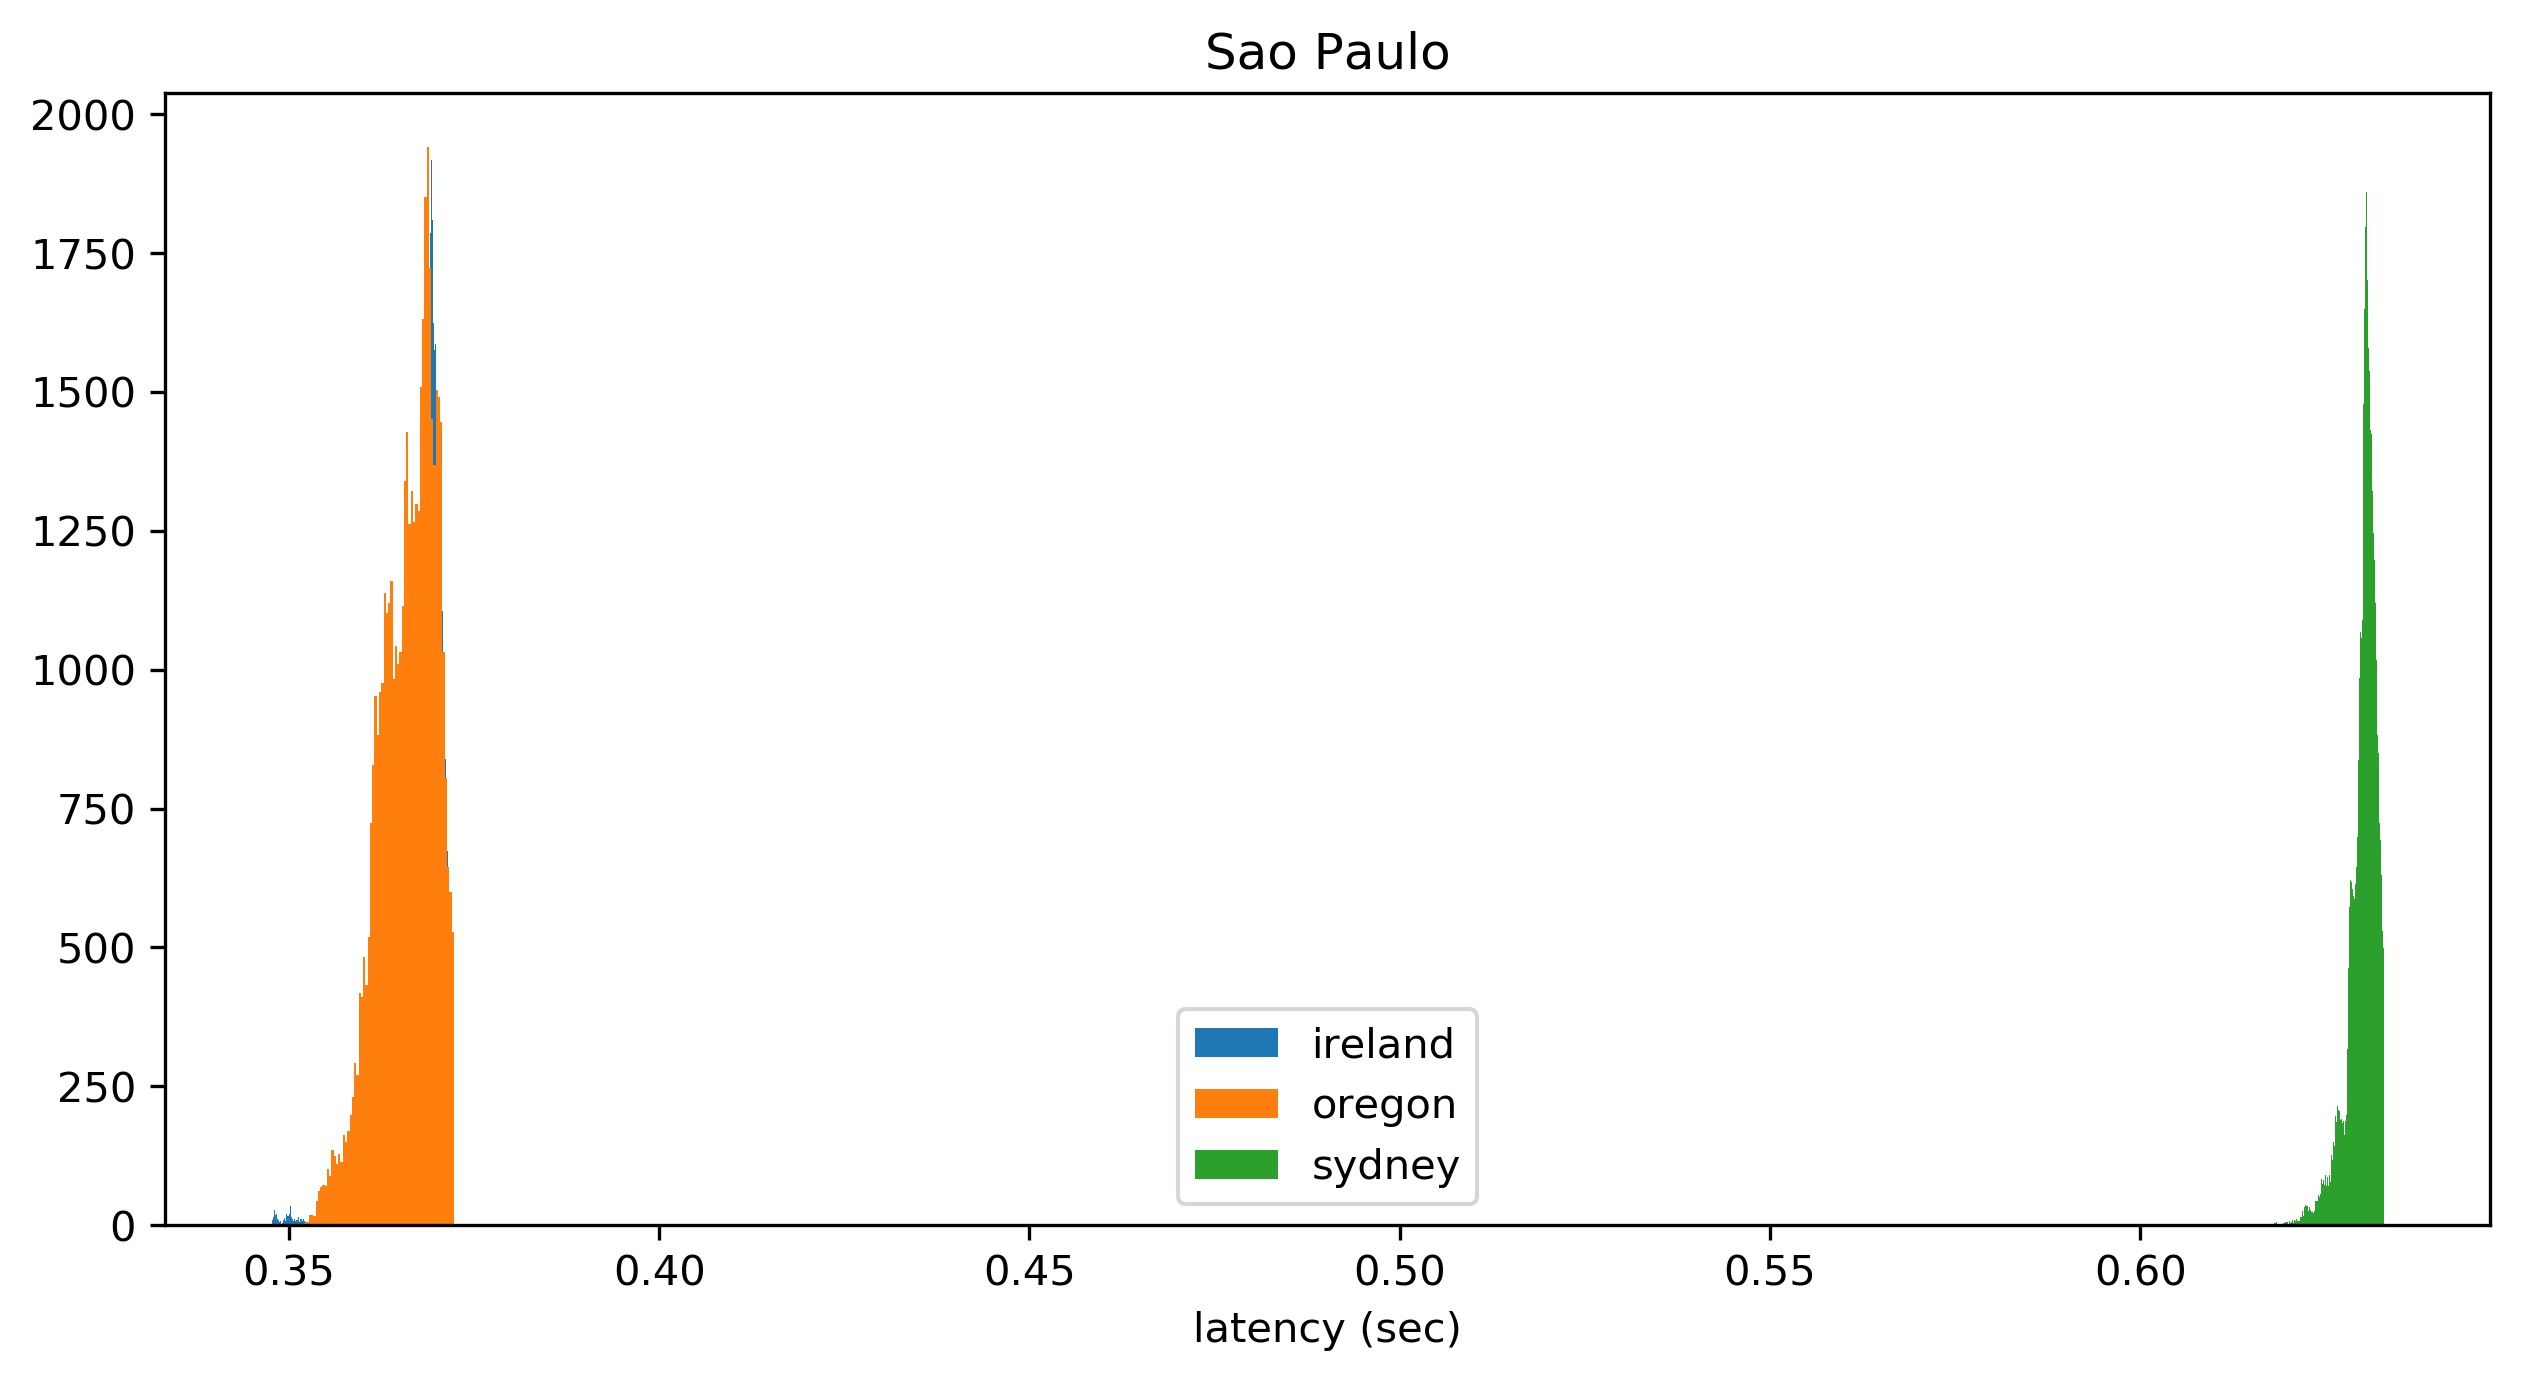

In [39]:
plt.hist(df95Grouped.get_group(('saopaulo','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('saopaulo','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('saopaulo','sydney'))['latency'], bins='auto', histtype='bar', label='sydney')
plt.title("Sao Paulo")
plt.xlabel('latency (sec)')
plt.legend()
plt.savefig("saopaulo-march.png")

### Sydney

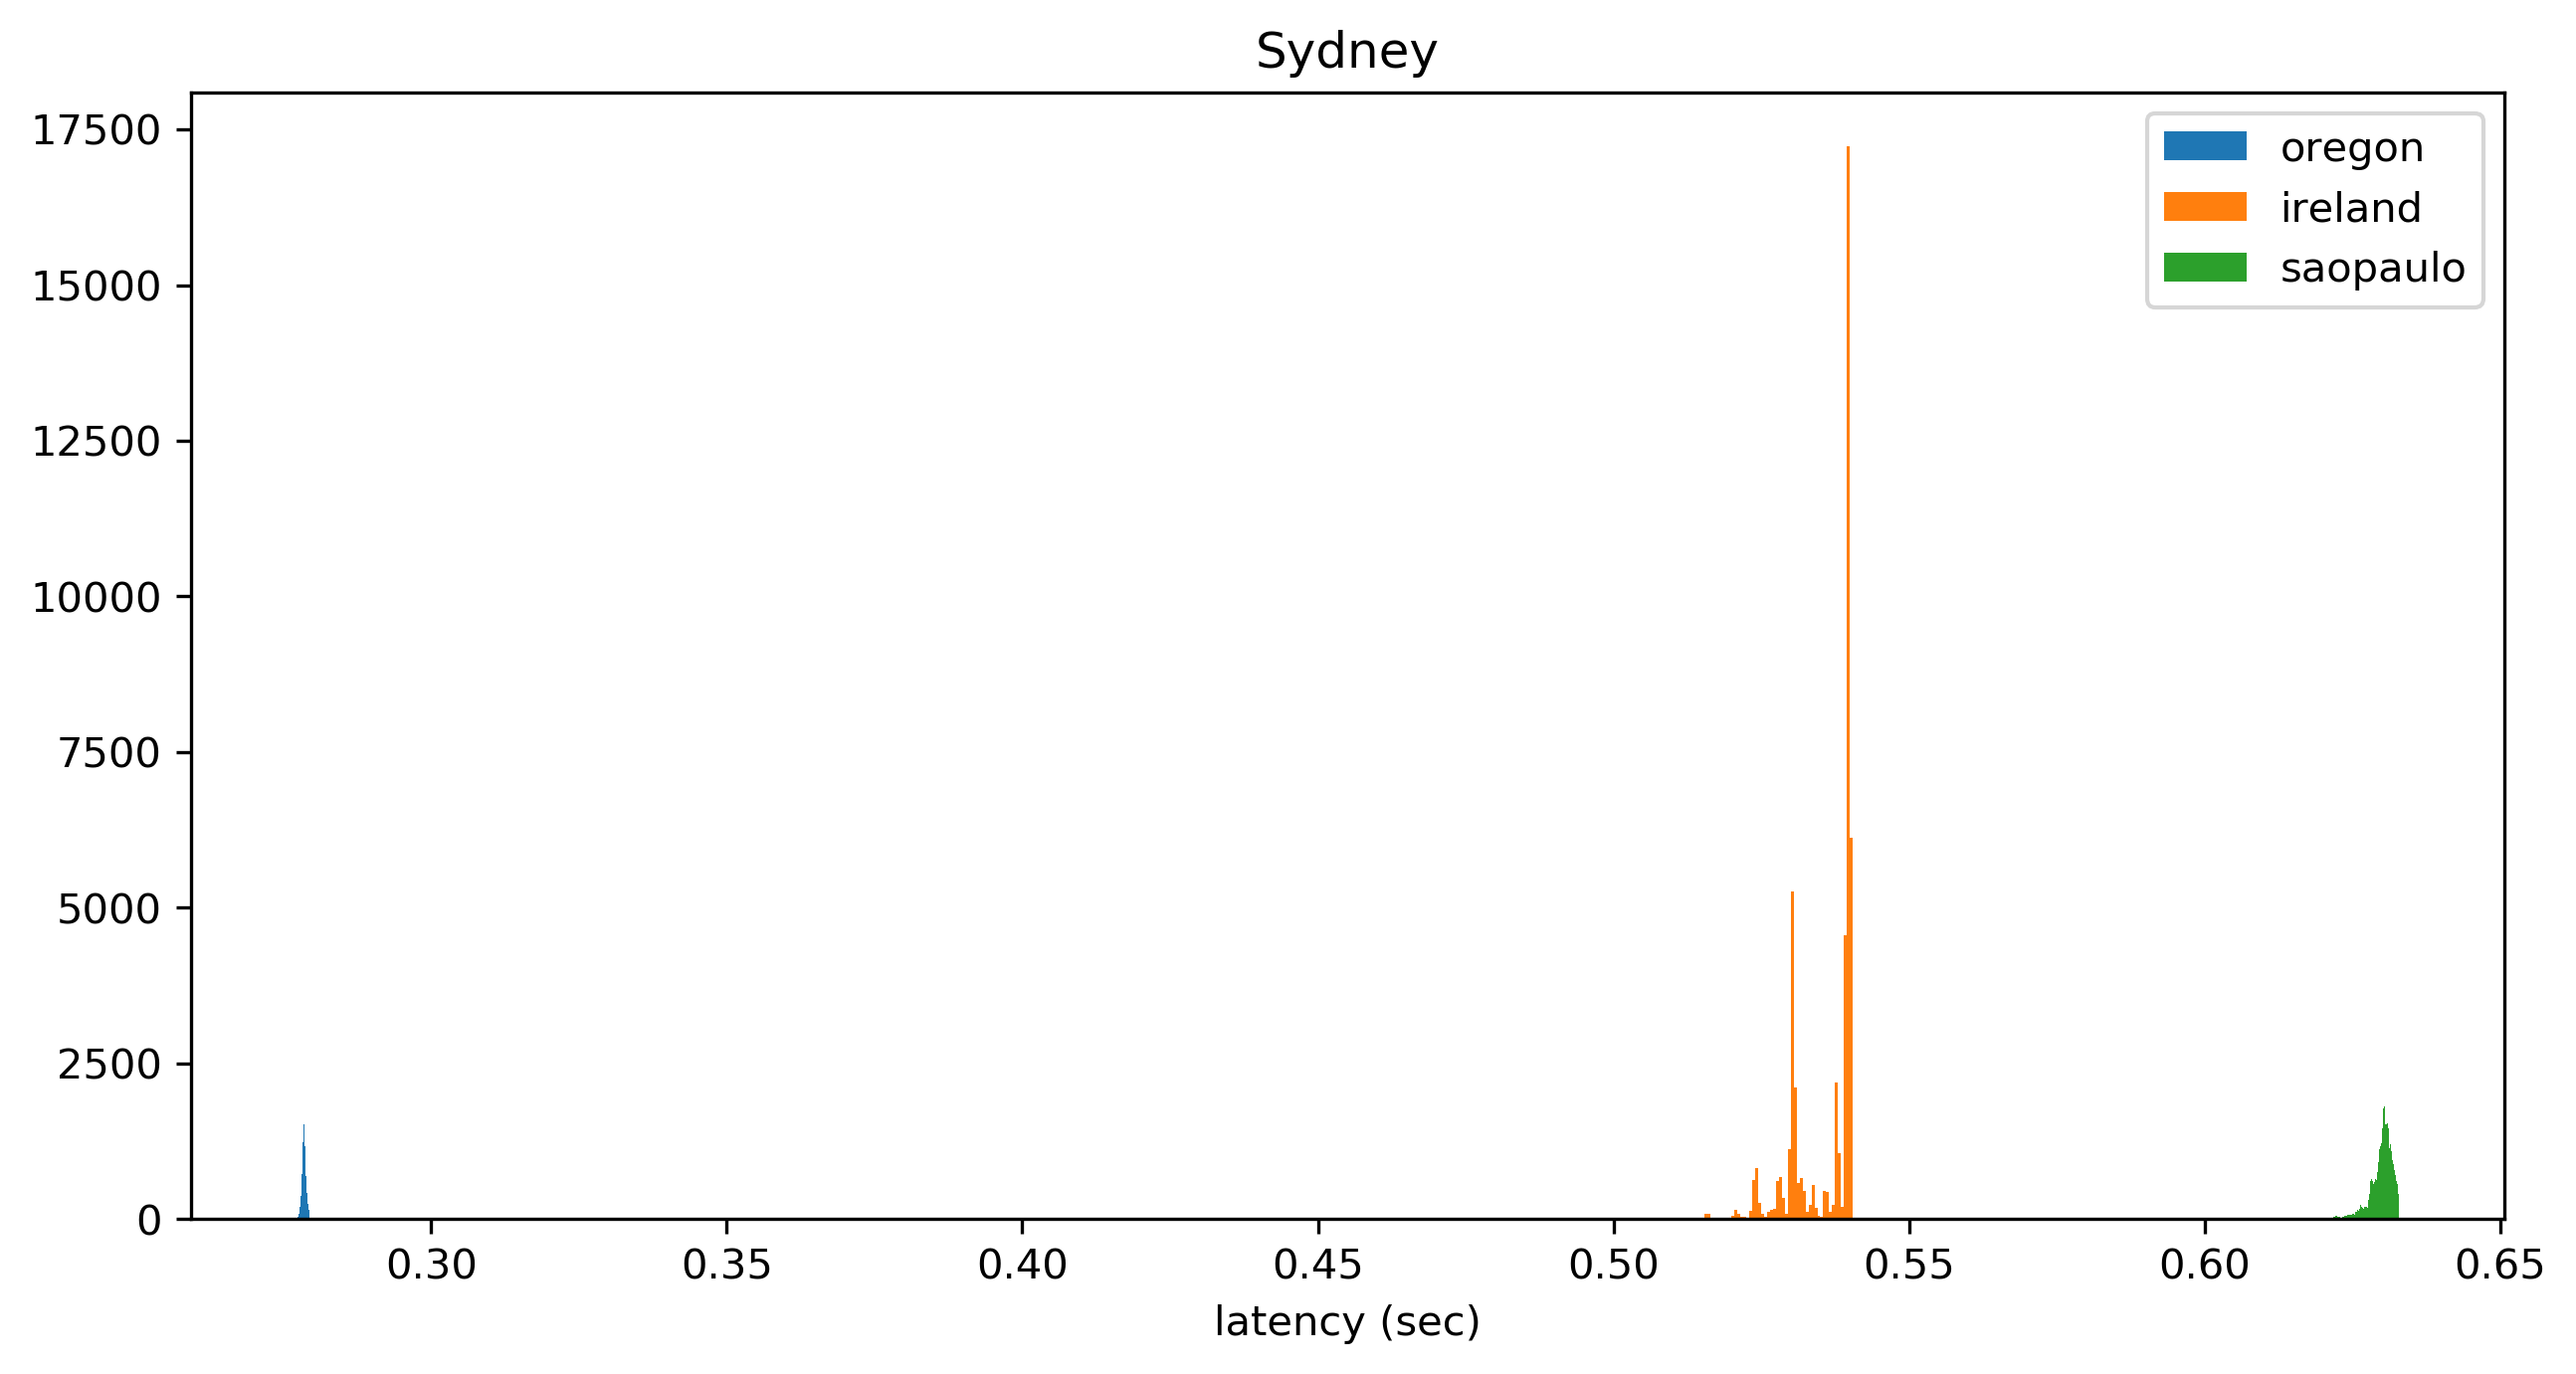

In [40]:
plt.hist(df95Grouped.get_group(('sydney','oregon'))['latency'], bins='auto', histtype='bar', label='oregon')
plt.hist(df95Grouped.get_group(('sydney','ireland'))['latency'], bins='auto', histtype='bar', label='ireland')
plt.hist(df95Grouped.get_group(('sydney','saopaulo'))['latency'], bins='auto', histtype='bar', label='saopaulo')
plt.title("Sydney")
plt.xlabel('latency (sec)')
plt.legend()
plt.savefig("sydney-march.png")

===============================================================
===============================================================

## Time series analysis

In [17]:
df_ts = df.set_index('created_at')
df95_ts = df95.set_index('created_at')
df_ts_grouped = df_ts.groupby(['origin','destination'])
df95_ts_grouped = df95_ts.groupby(['origin','destination'])

In [18]:
iolatency = df_ts_grouped.get_group(('ireland','oregon'))['latency']
isaolatency = df_ts_grouped.get_group(('ireland','saopaulo'))['latency']
isydlatency = df_ts_grouped.get_group(('ireland','sydney'))['latency']

oilatency = df_ts_grouped.get_group(('oregon','ireland'))['latency']
osaolatency = df_ts_grouped.get_group(('oregon','saopaulo'))['latency']
osydlatency = df_ts_grouped.get_group(('oregon','sydney'))['latency']

saoreglatency = df_ts_grouped.get_group(('saopaulo','oregon'))['latency']
saoilatency = df_ts_grouped.get_group(('saopaulo','ireland'))['latency']
saosydlatency = df_ts_grouped.get_group(('saopaulo','sydney'))['latency']

sydolatency = df_ts_grouped.get_group(('sydney','oregon'))['latency']
sydsaolatency = df_ts_grouped.get_group(('sydney','saopaulo'))['latency']
sydilatency = df_ts_grouped.get_group(('sydney','ireland'))['latency']

iolatency95 = df95_ts_grouped.get_group(('ireland','oregon'))['latency']

In [19]:
df_ts.index

DatetimeIndex(['2019-02-23 20:44:49', '2019-02-23 20:44:49',
               '2019-02-23 20:44:49', '2019-02-23 20:44:52',
               '2019-02-23 20:44:52', '2019-02-23 20:44:52',
               '2019-02-23 20:44:55', '2019-02-23 20:44:55',
               '2019-02-23 20:44:55', '2019-02-23 20:45:00',
               ...
               '2019-03-31 10:38:53', '2019-03-31 10:38:59',
               '2019-03-31 10:39:00', '2019-03-31 10:39:00',
               '2019-03-31 10:39:04', '2019-03-31 10:39:04',
               '2019-03-31 10:39:05', '2019-03-31 10:39:11',
               '2019-03-31 10:39:11', '2019-03-31 10:39:11'],
              dtype='datetime64[ns]', name='created_at', length=614816, freq=None)

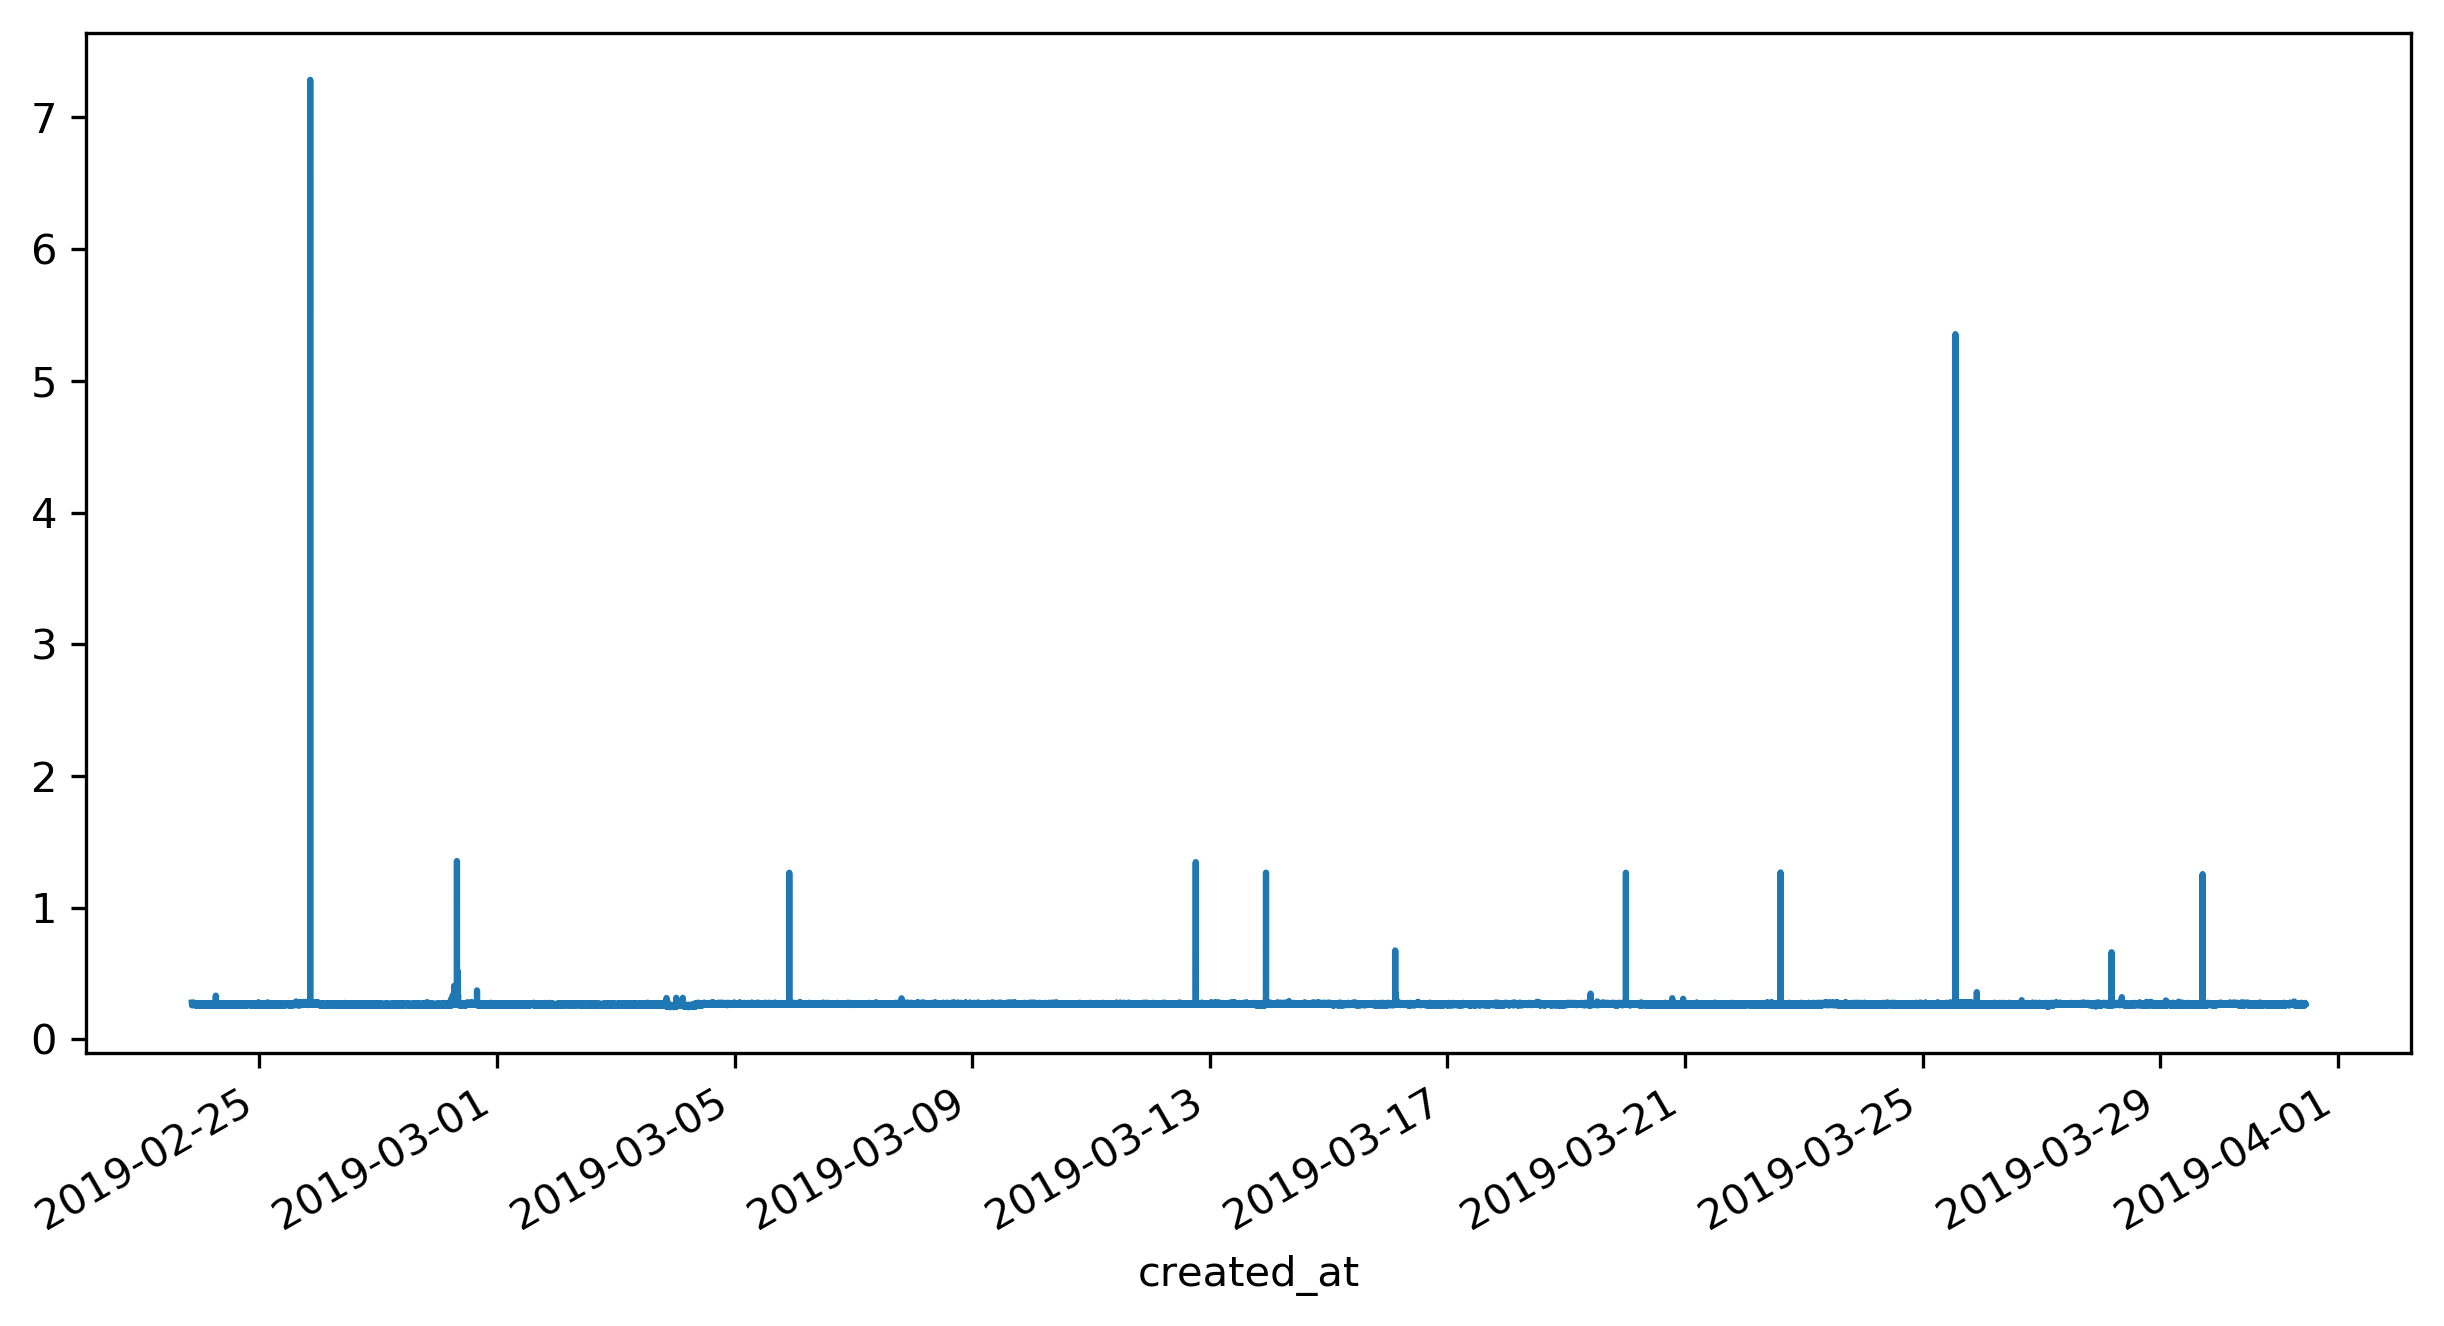

In [20]:
iolatency['2019-02-23':'2019-03-31'].plot()

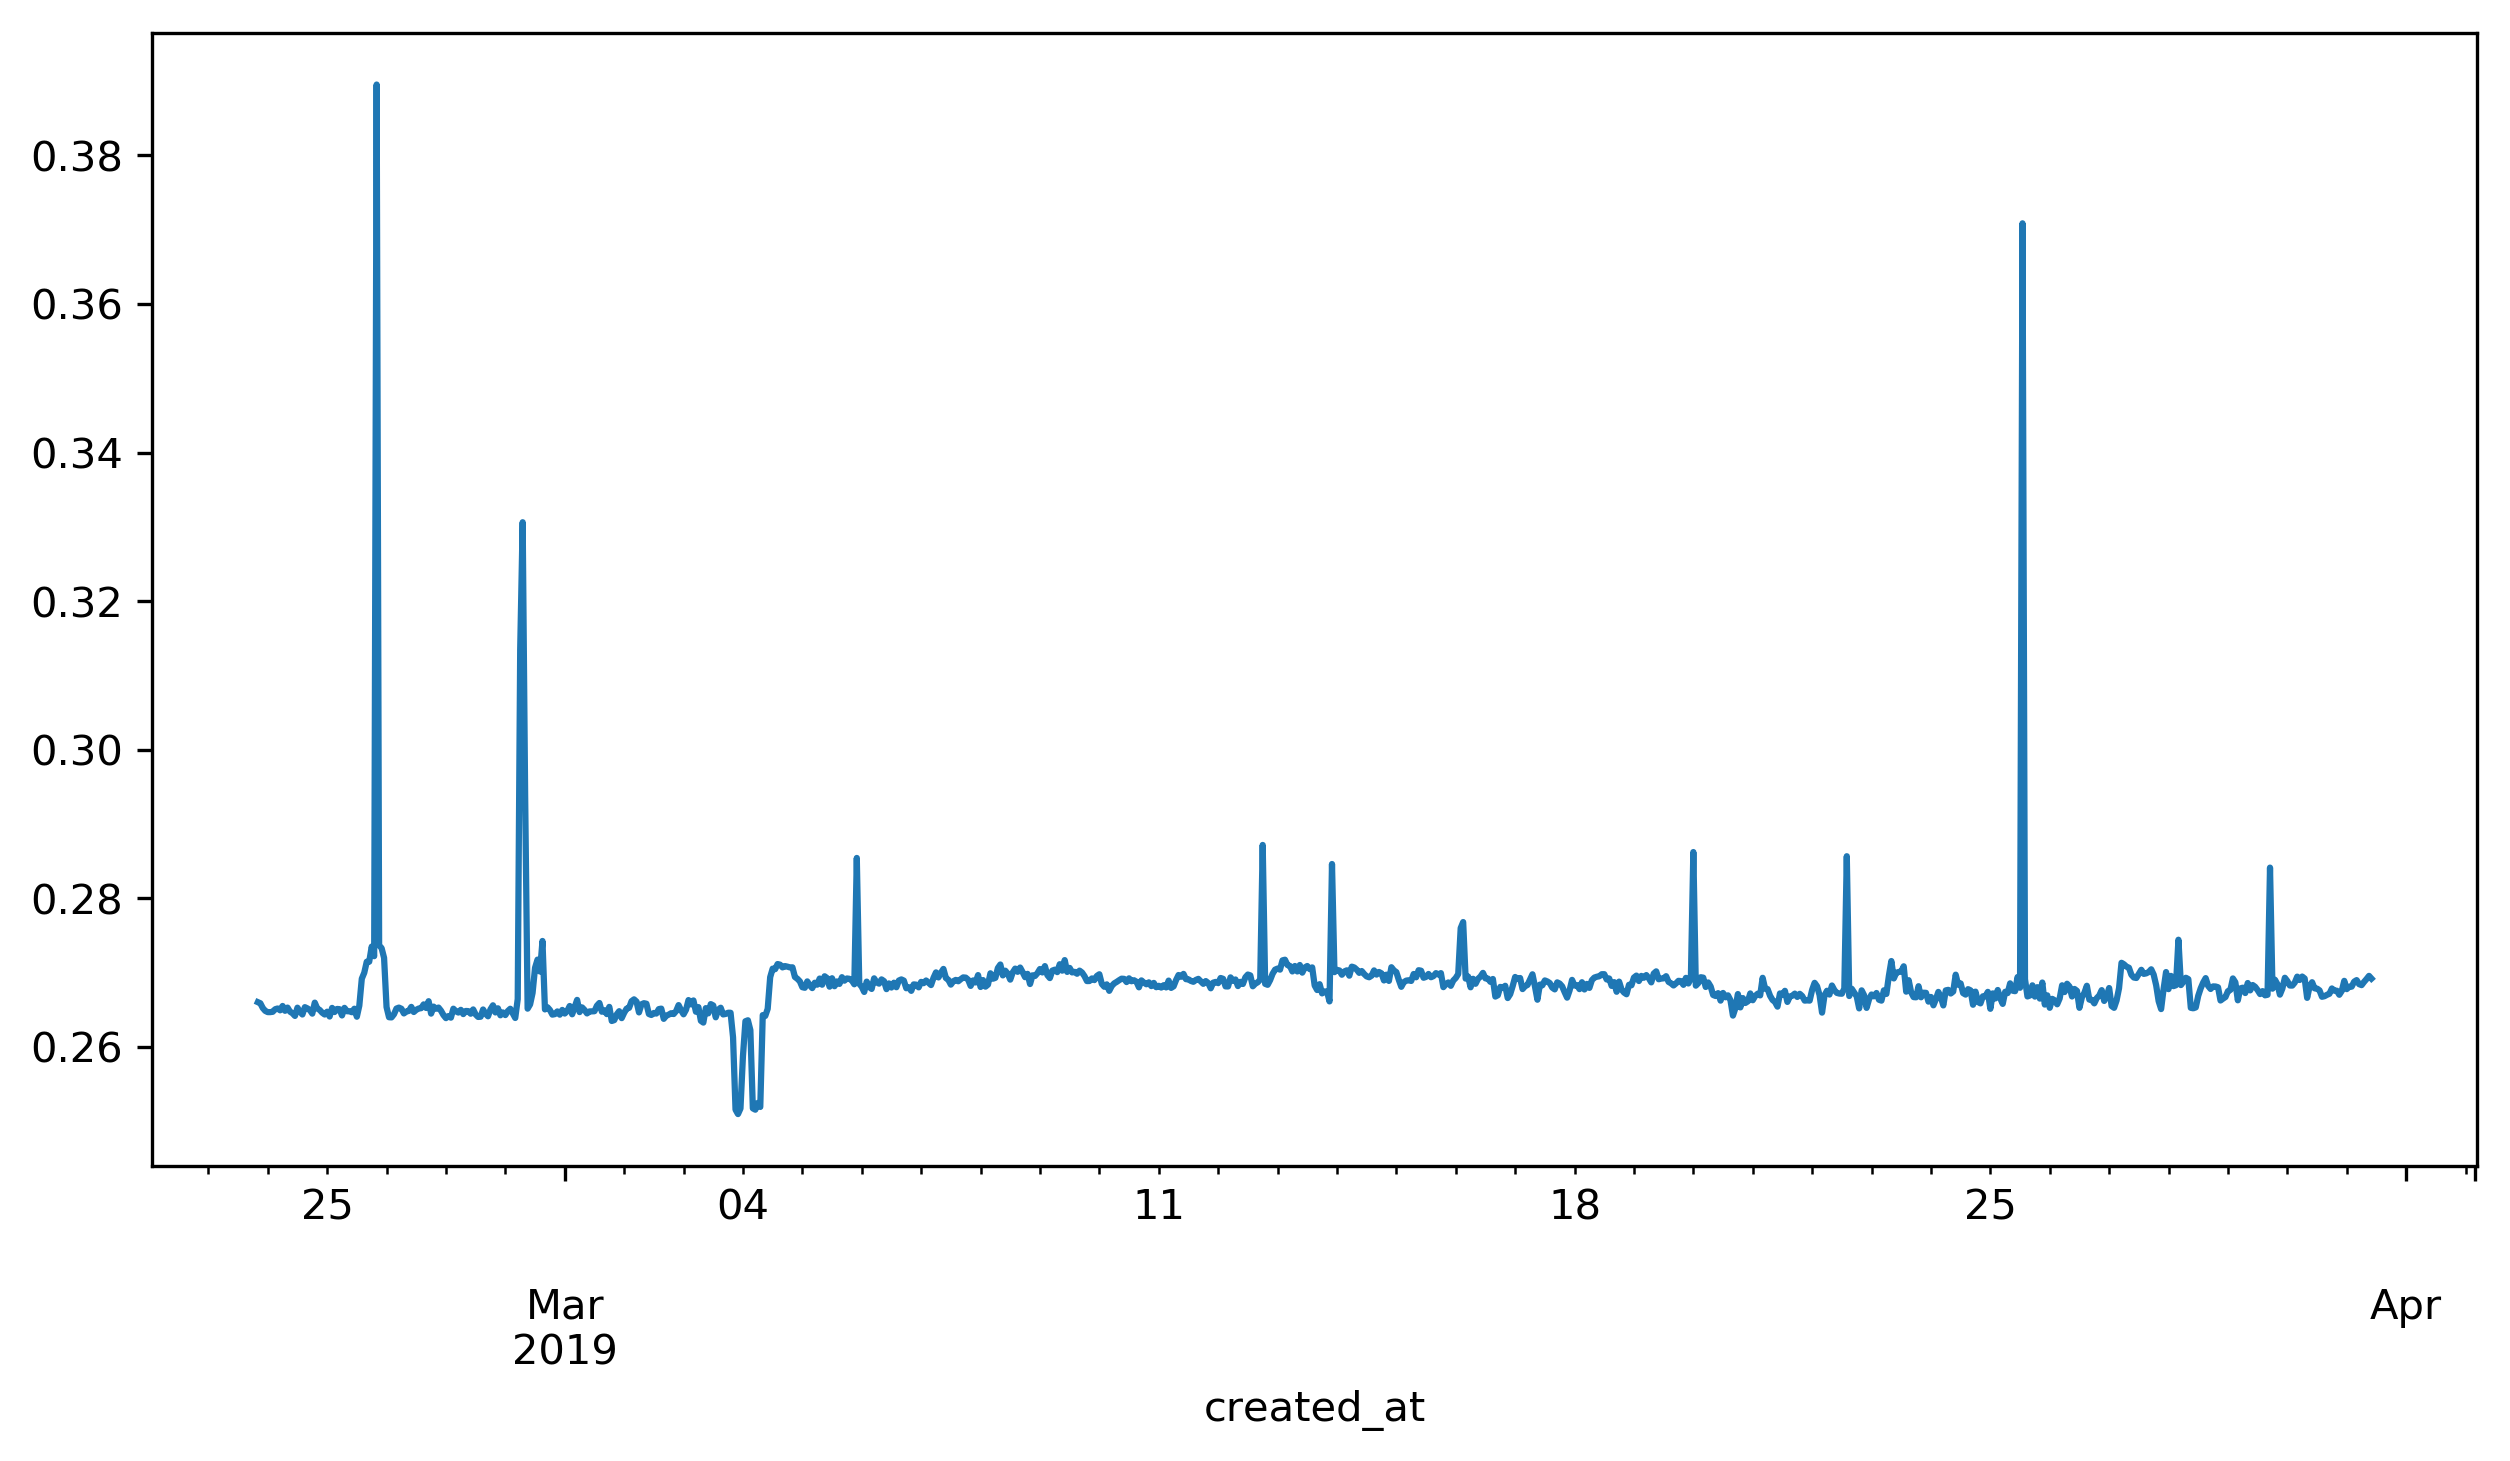

In [21]:
#resampling by hour
iolatency.resample('H').mean().plot()

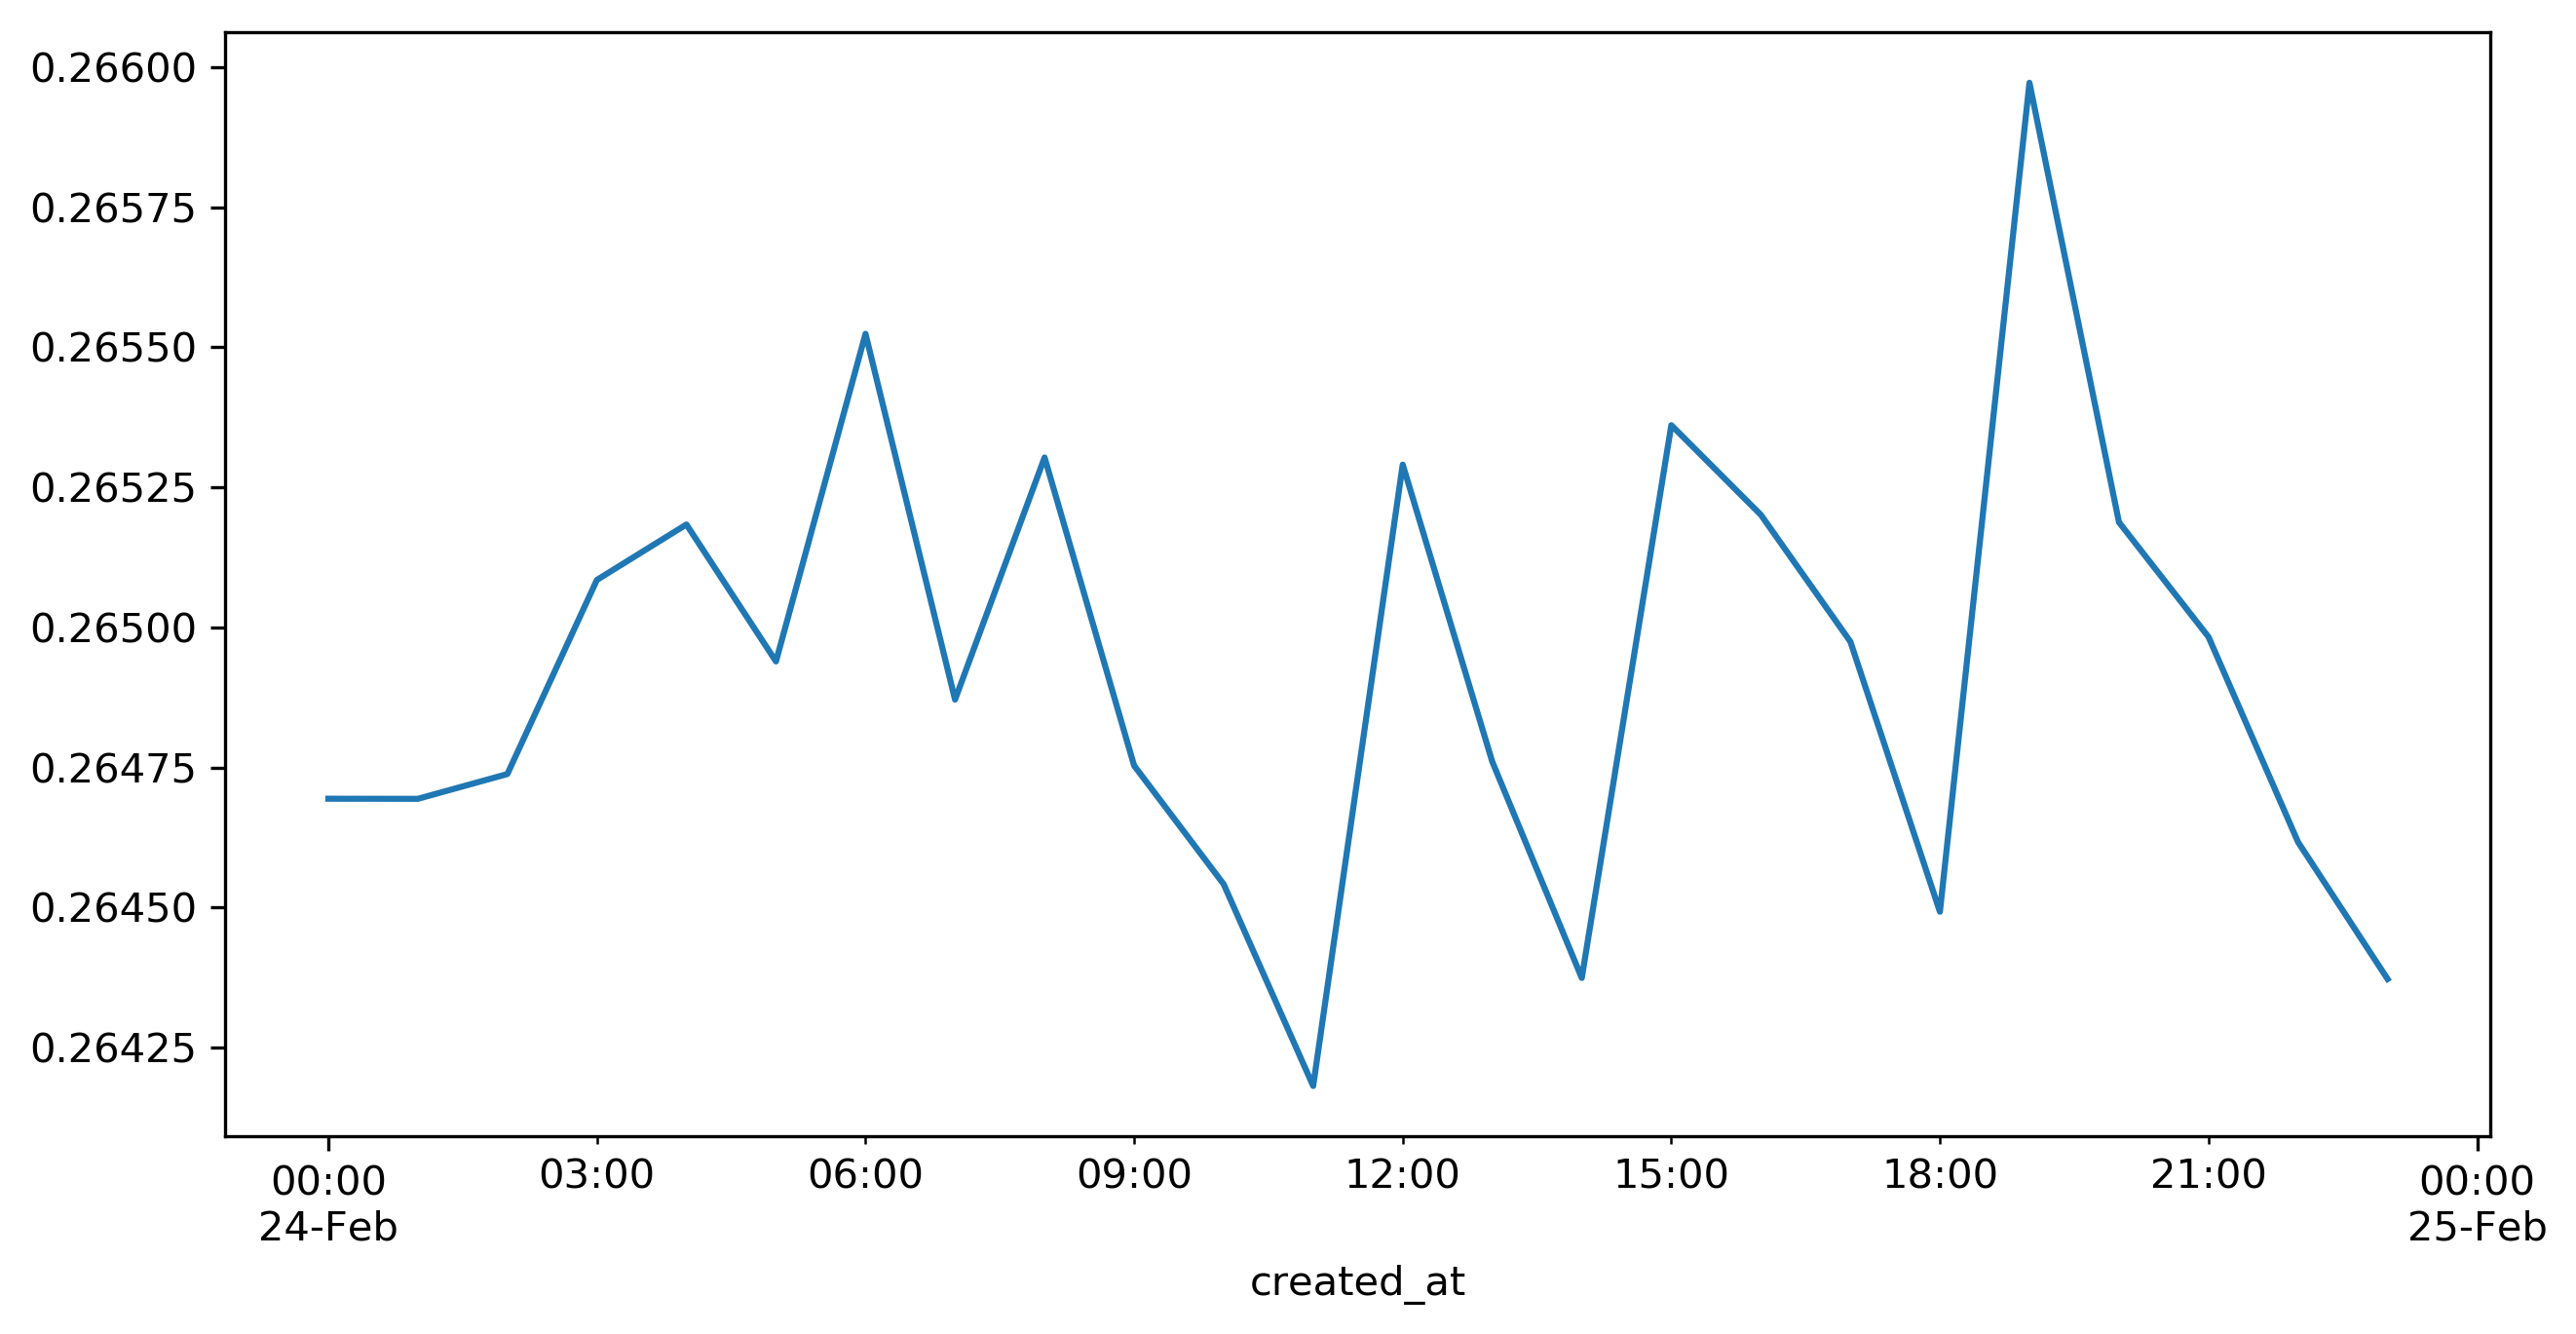

In [22]:
iolatency['24-2-2019'].resample('H').mean().plot()

In [23]:
daily_rng = pd.date_range('23-2-2019', periods=36, freq='D')
daily_rng

DatetimeIndex(['2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26',
               '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-02',
               '2019-03-03', '2019-03-04', '2019-03-05', '2019-03-06',
               '2019-03-07', '2019-03-08', '2019-03-09', '2019-03-10',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-15', '2019-03-16', '2019-03-17', '2019-03-18',
               '2019-03-19', '2019-03-20', '2019-03-21', '2019-03-22',
               '2019-03-23', '2019-03-24', '2019-03-25', '2019-03-26',
               '2019-03-27', '2019-03-28', '2019-03-29', '2019-03-30'],
              dtype='datetime64[ns]', freq='D')

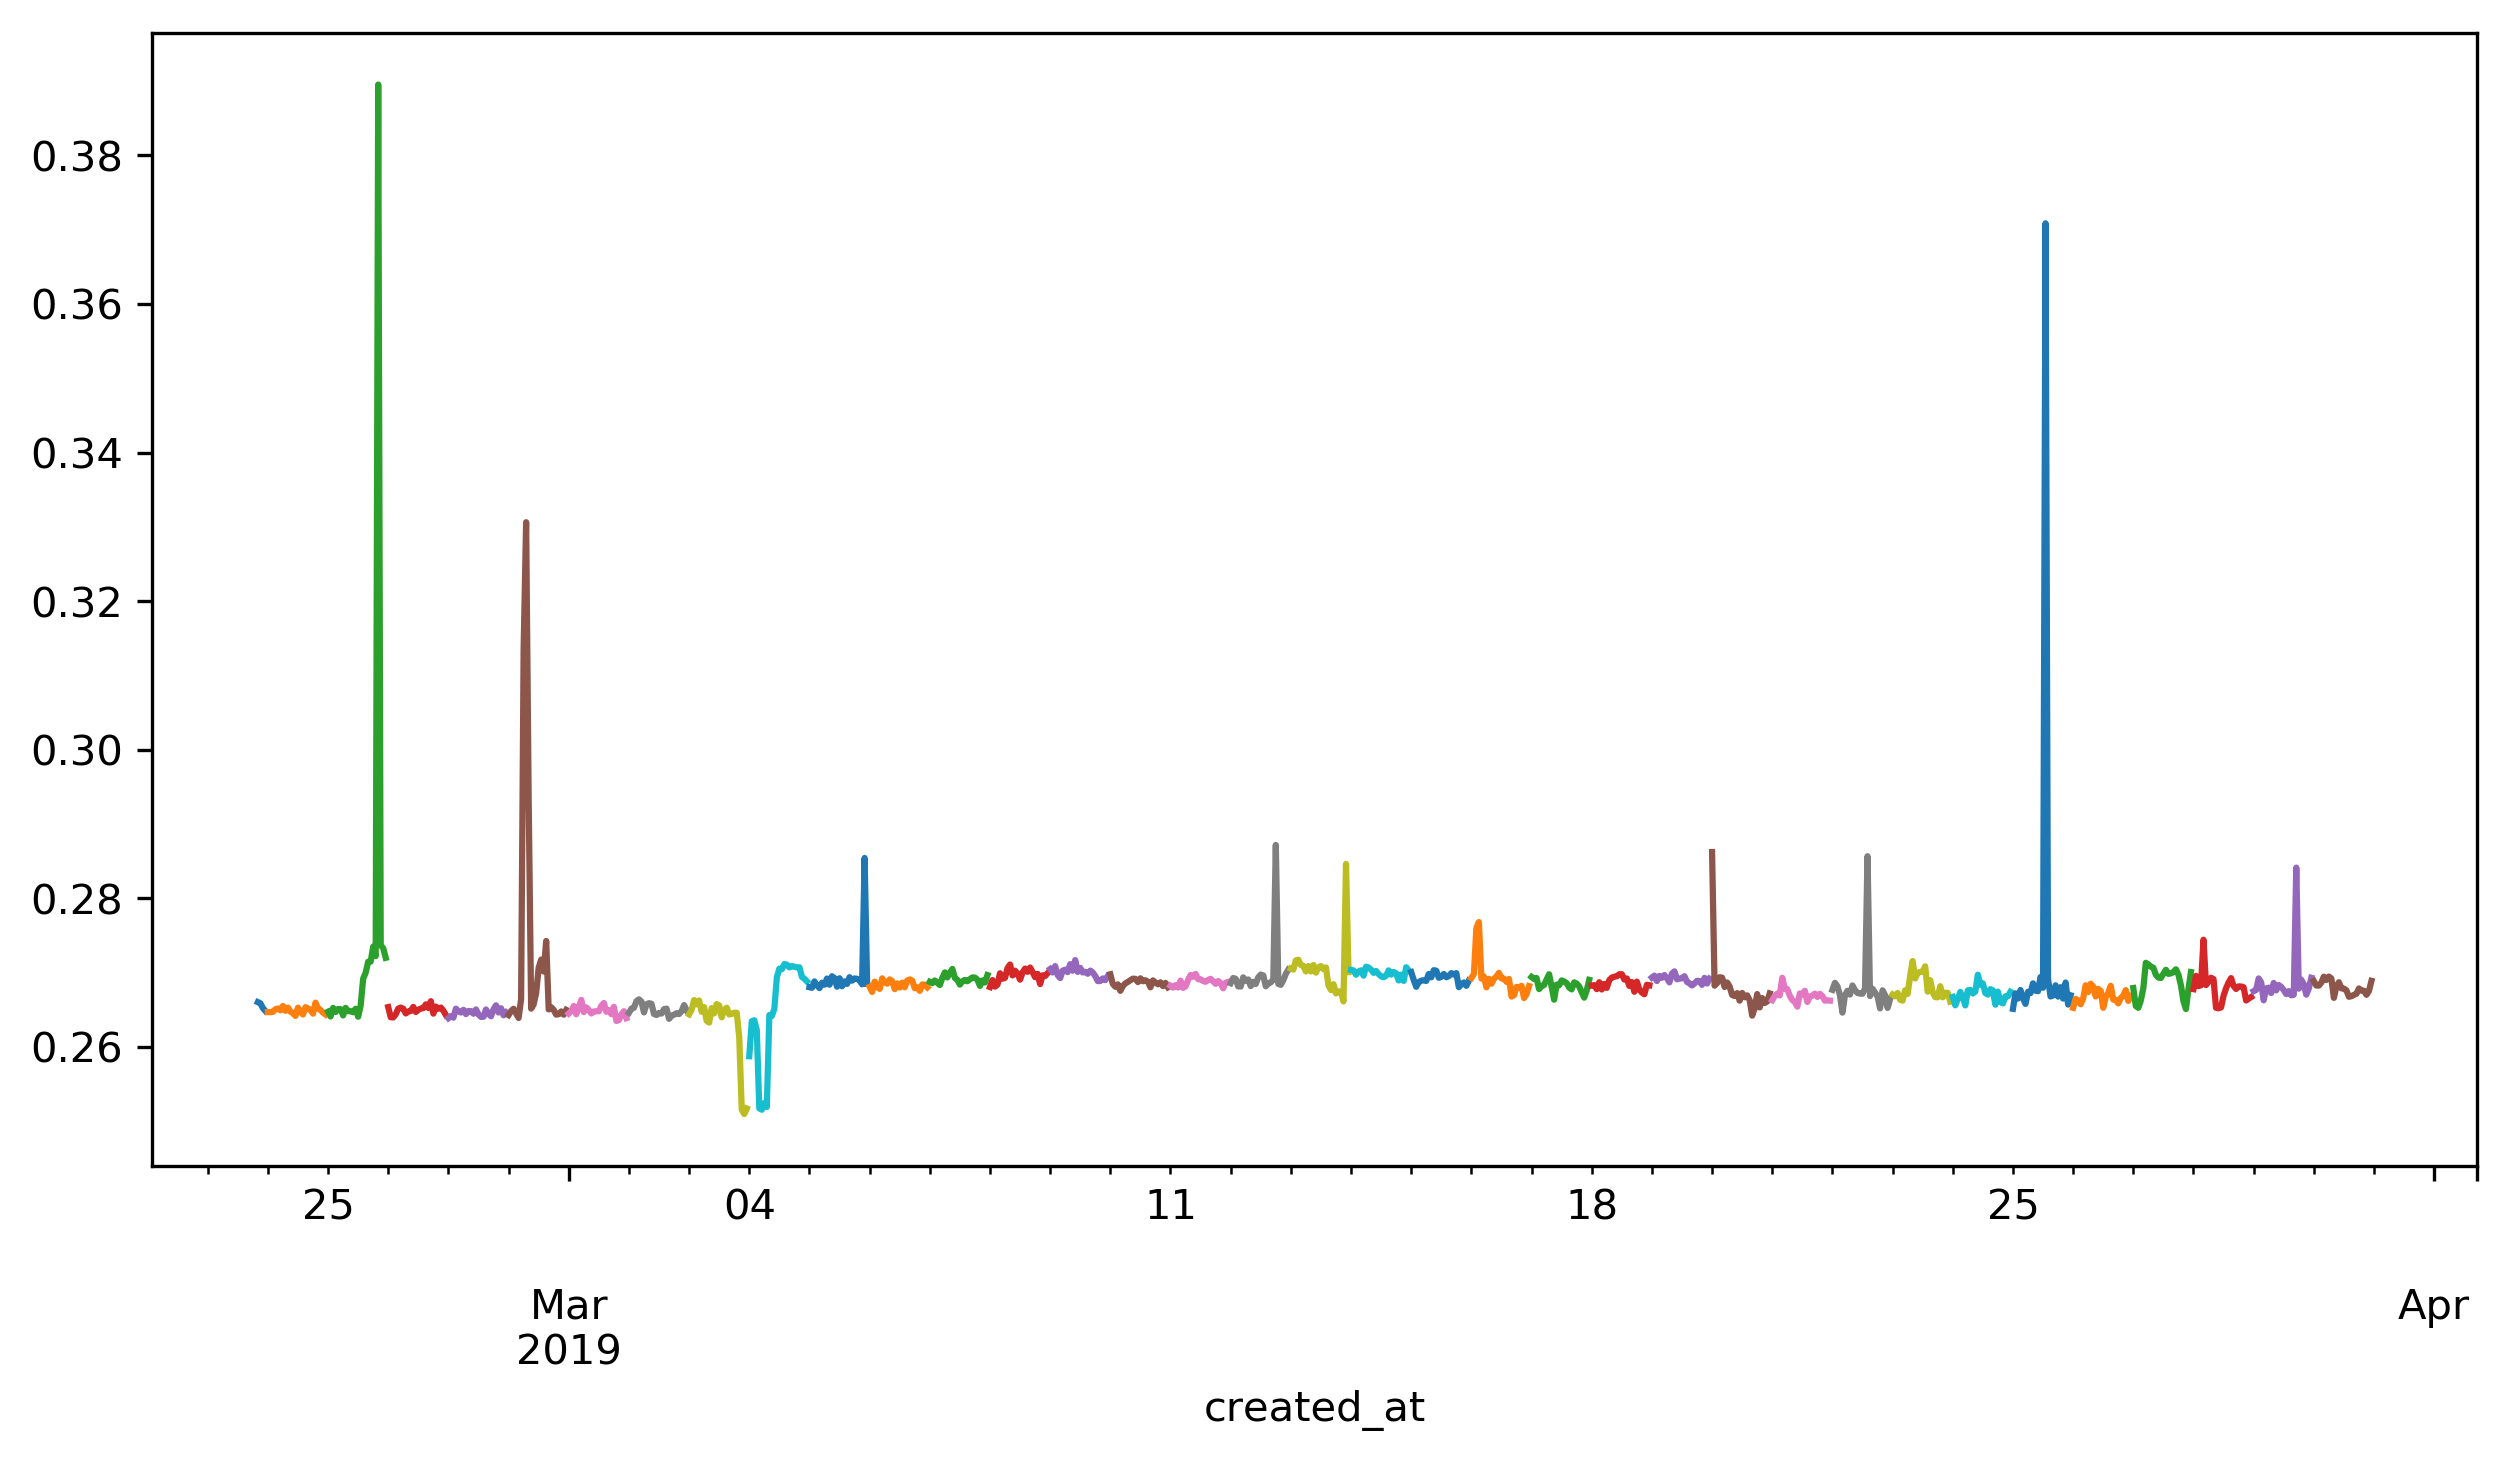

In [24]:
for i in daily_rng:
    iolatency[str(i.year)+'-'+str(i.month)+'-'+str(i.day)].resample('H').mean().plot()

In [25]:
hourly_rng = pd.date_range('23-2-2019', periods=36*24, freq='H')

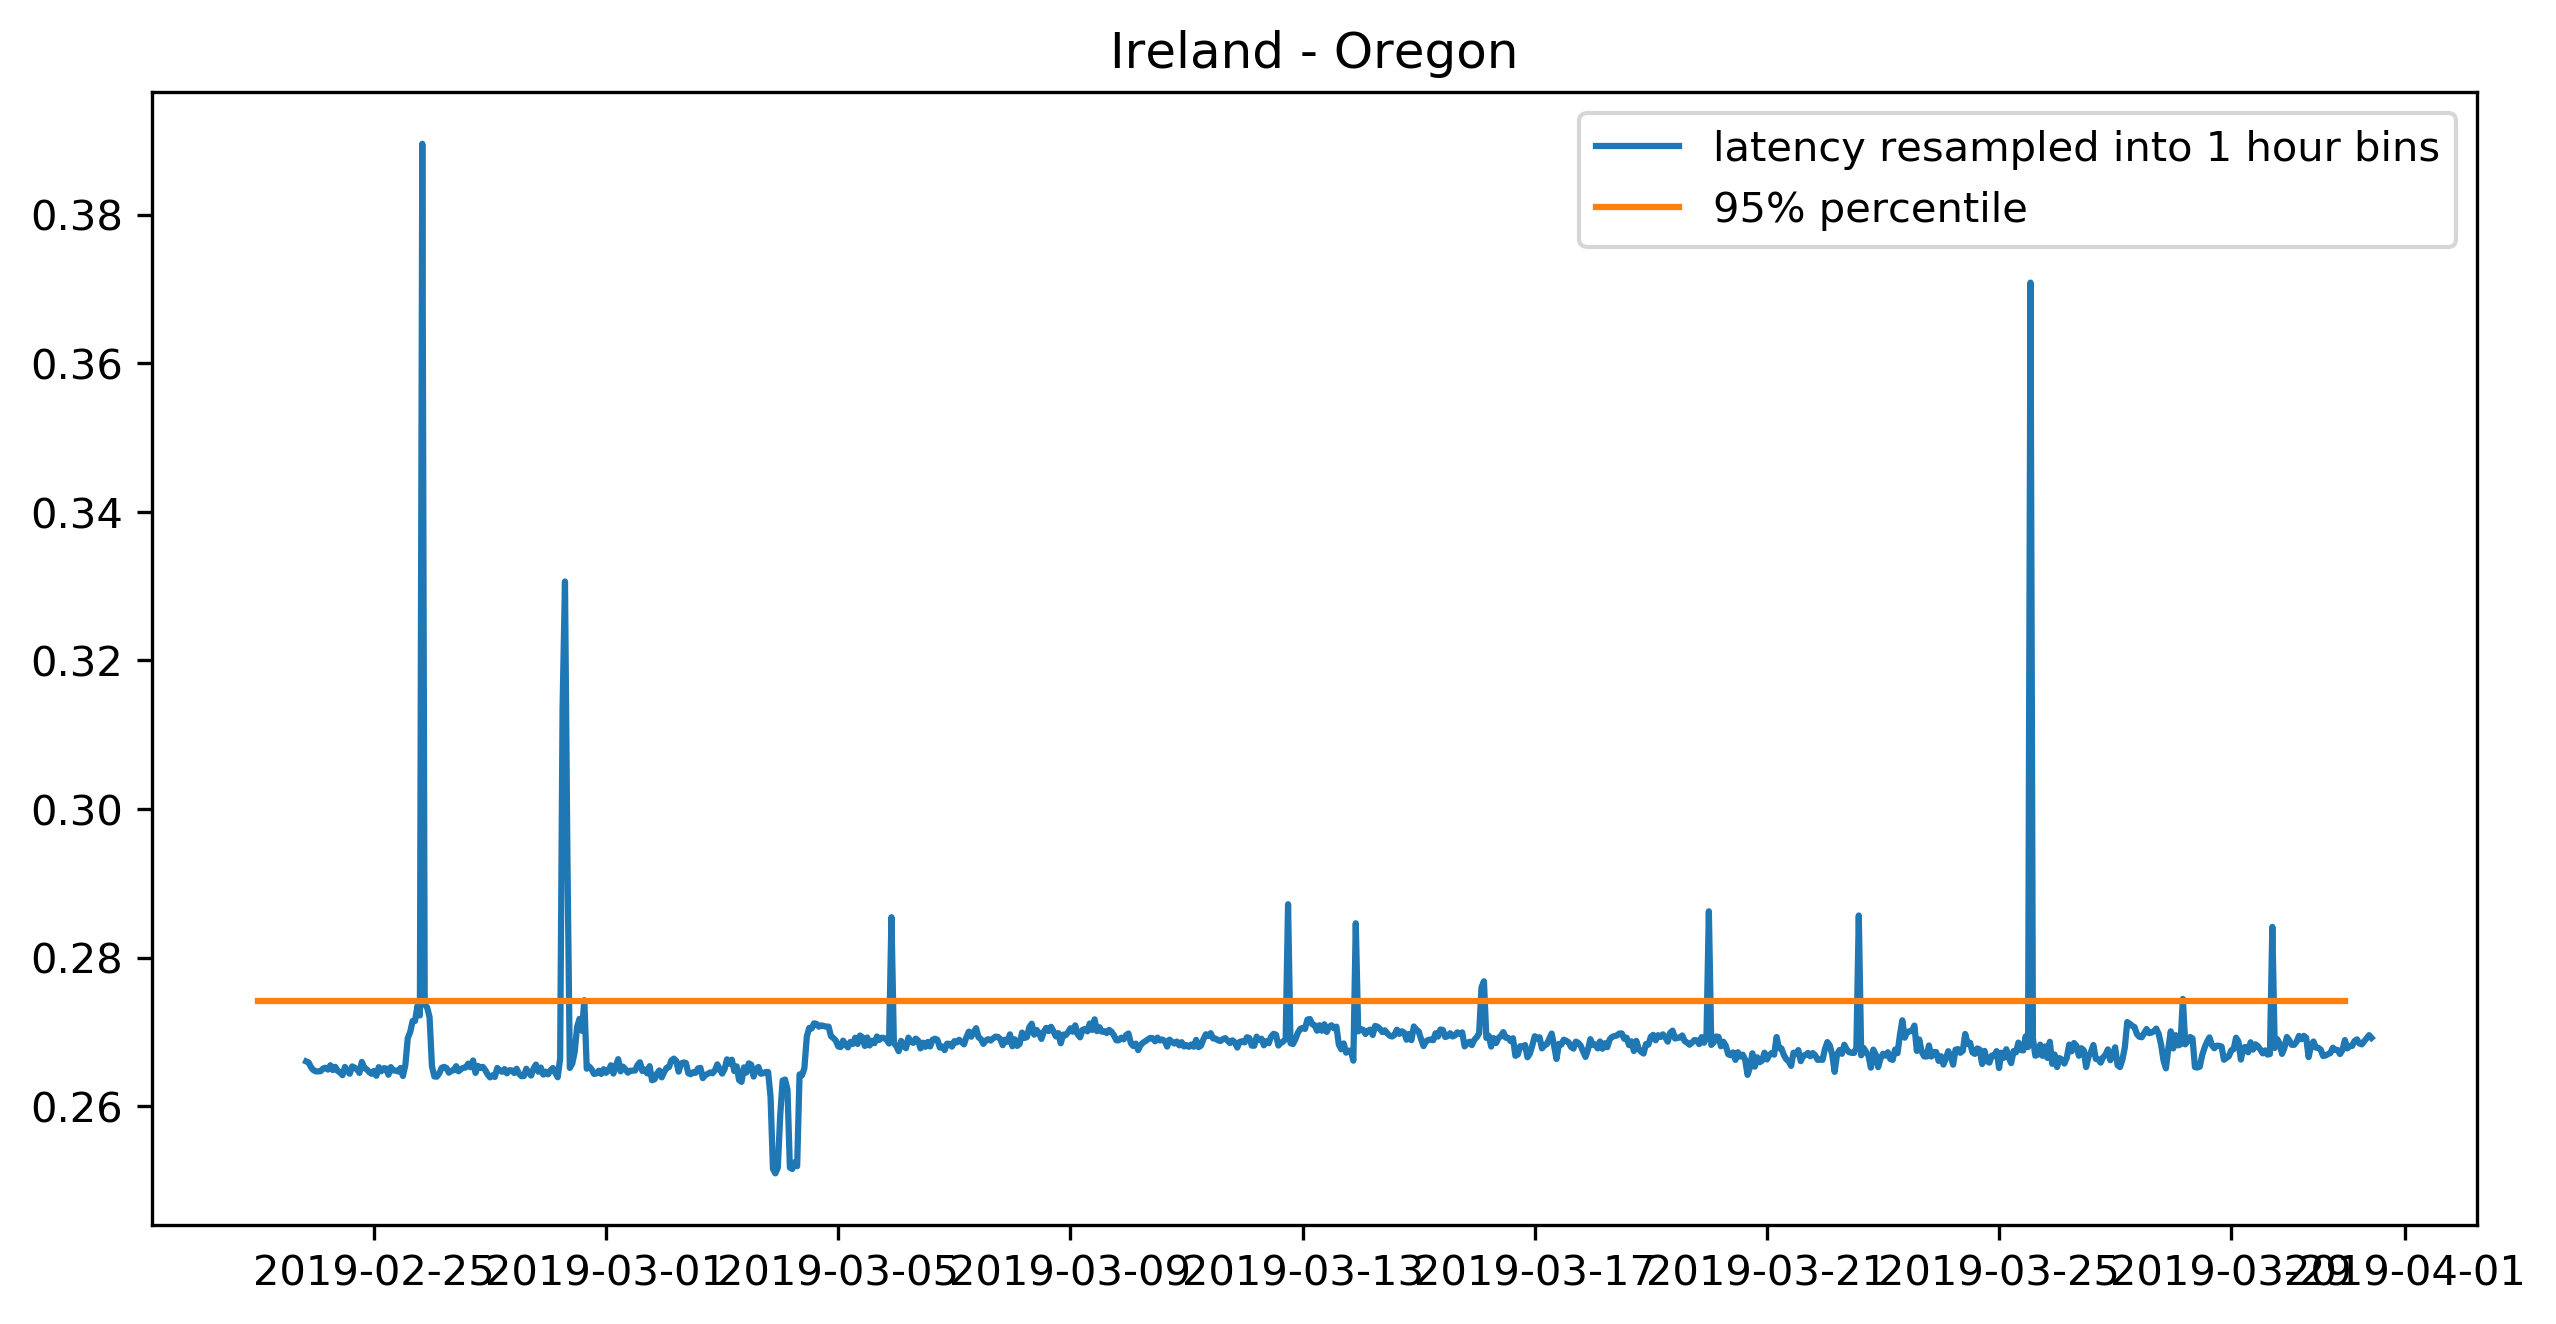

In [47]:
plt.plot(iolatency.resample('1H').mean(), label="latency resampled into 1 hour bins")
plt.plot(hourly_rng, [statistics_df.loc[('ireland','oregon'),('latency','95%')]]*len(hourly_rng), label="95% percentile")
plt.title("Ireland - Oregon")
plt.legend()
plt.savefig("ireland-oregon-march.png")

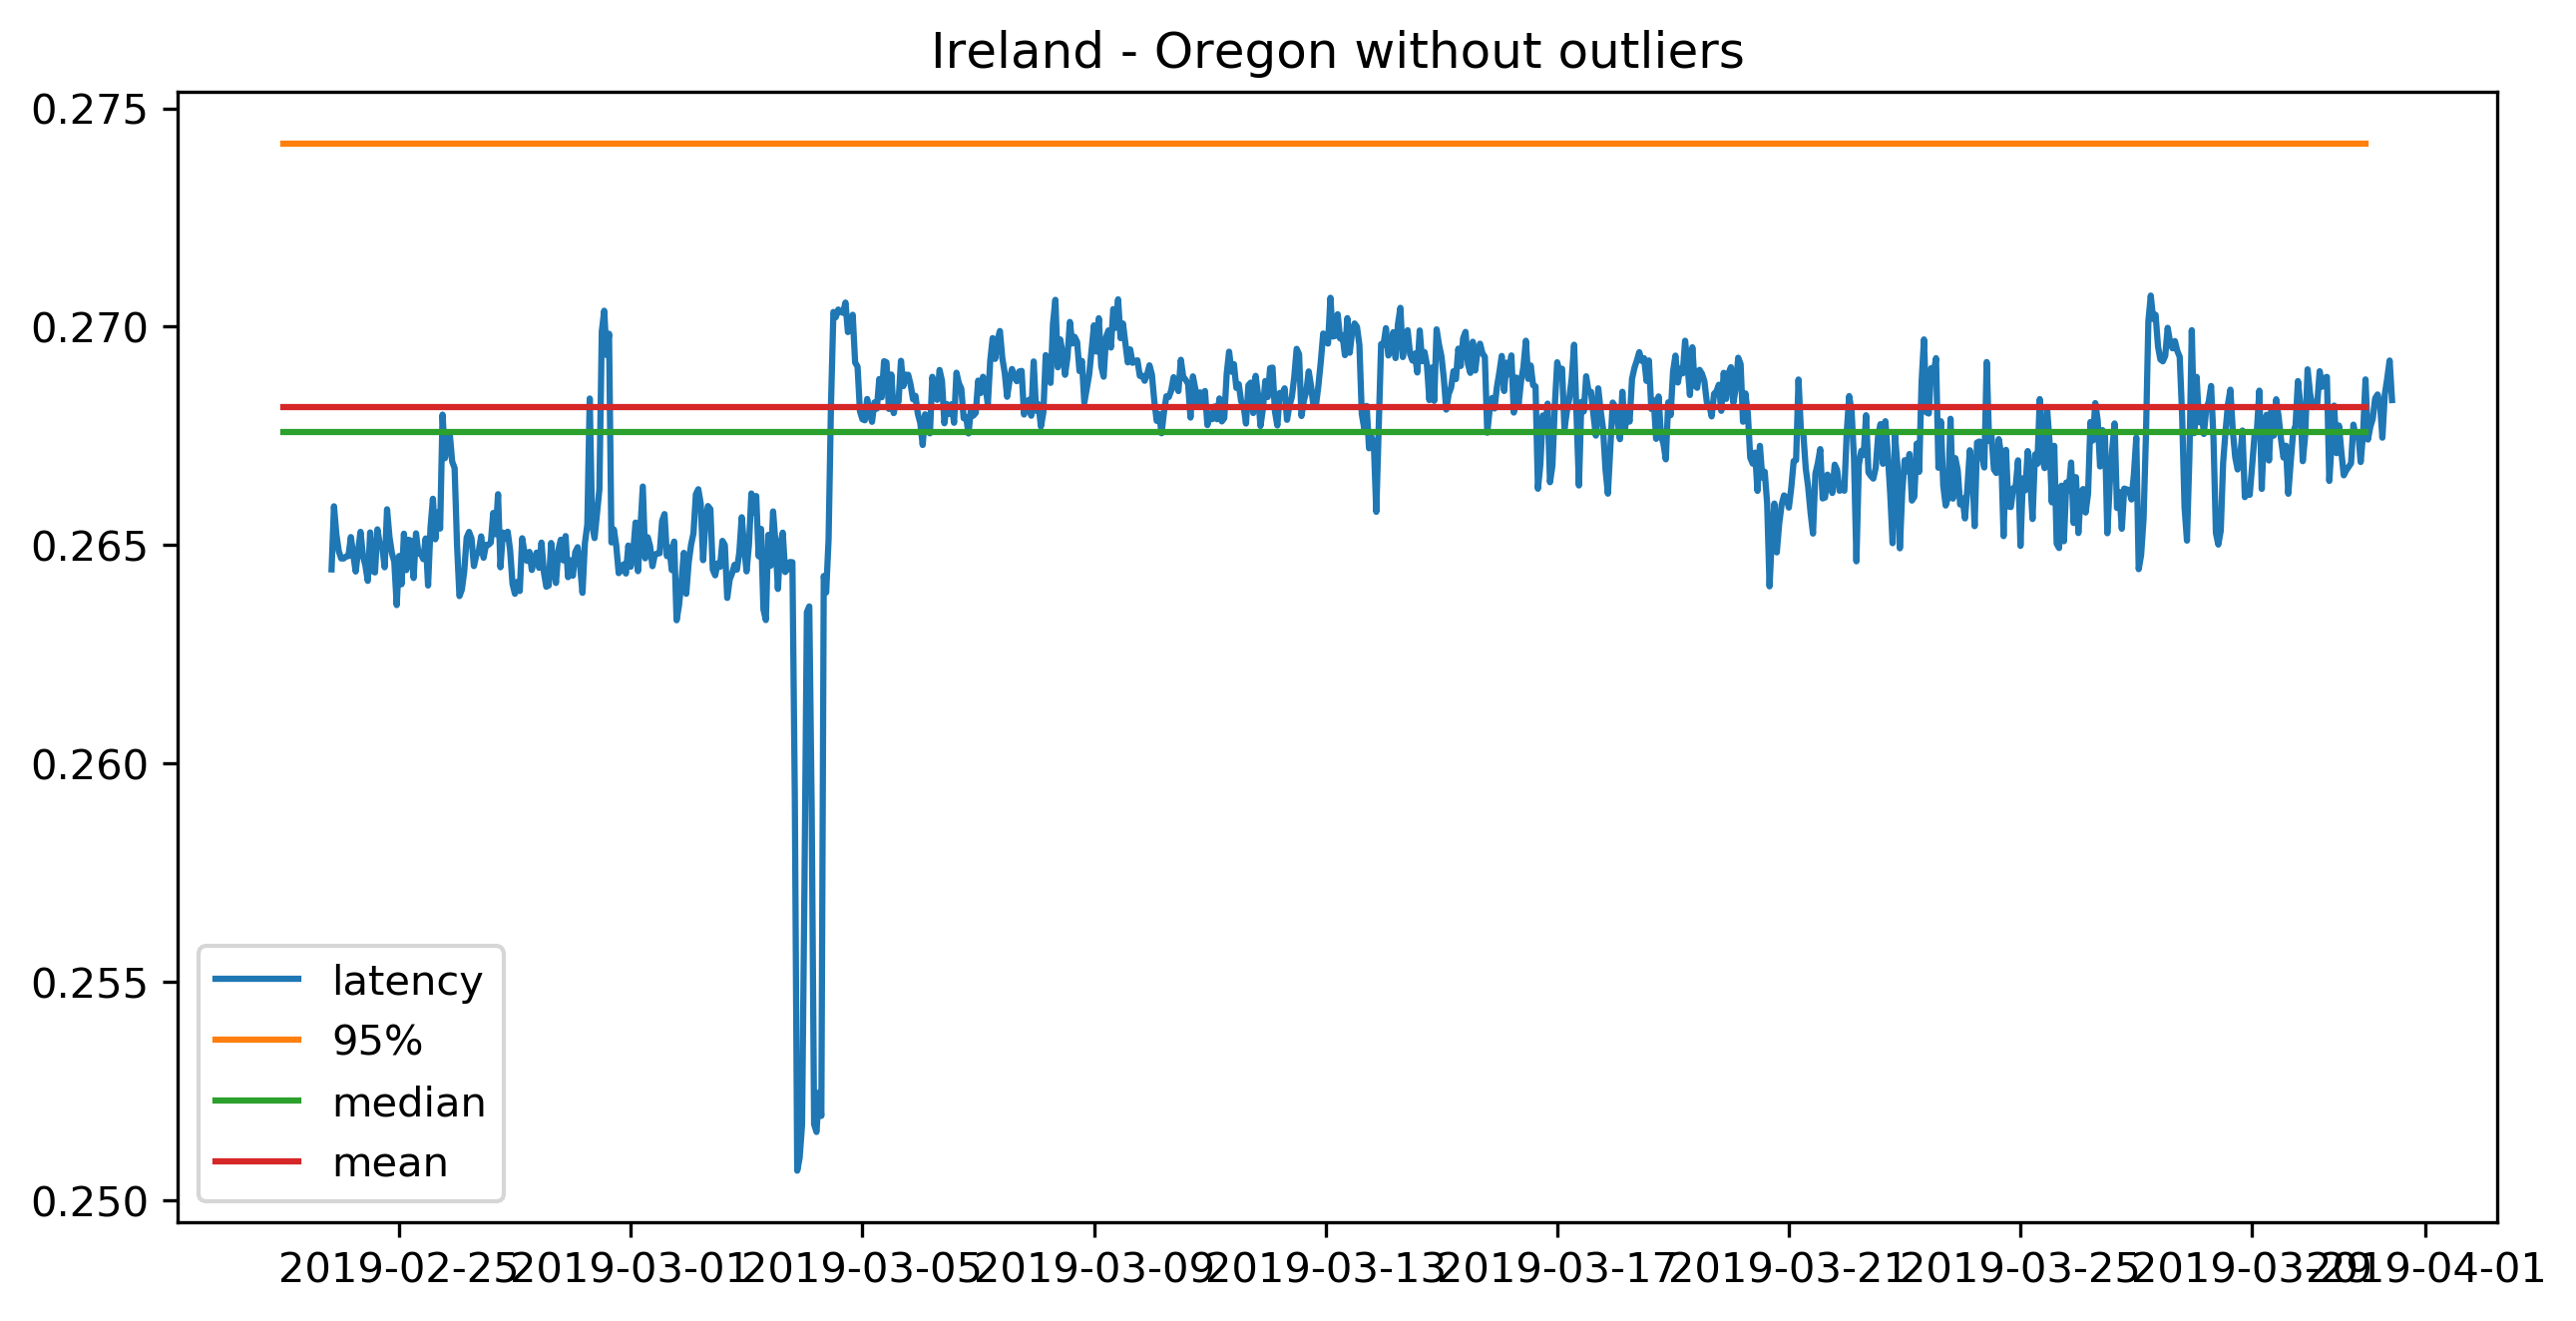

In [51]:
plt.plot(iolatency95.resample('1H').mean())
plt.plot(hourly_rng, [statistics_df.loc[('ireland','oregon'),('latency','95%')]]*len(hourly_rng), label='95%')
plt.plot(hourly_rng, [statistics_df.loc[('ireland','oregon'),('latency','50%')]]*len(hourly_rng), label='median')
plt.plot(hourly_rng, [statistics_df.loc[('ireland','oregon'),('latency','mean')]]*len(hourly_rng), label='mean')
plt.title("Ireland - Oregon without outliers")
plt.legend()
plt.savefig("ireland-oregon-march2.png")

===============================================================
===============================================================

## Distances

In [28]:
#distance in km
distance = {
"ireland_sydney":17209,
"ireland_oregon": 7486,
"ireland_saopaulo": 9354,
"oregon_sydney": 12342,
"oregon_saopaulo": 10825,
"sydney_saopaulo": 13386
}

sorted(distance.items(), key= lambda x: x[1])

[('ireland_oregon', 7486),
 ('ireland_saopaulo', 9354),
 ('oregon_saopaulo', 10825),
 ('oregon_sydney', 12342),
 ('sydney_saopaulo', 13386),
 ('ireland_sydney', 17209)]

In [29]:
speed_of_light = constants.c/1000 #km/s
speed_of_light

299792.458

In [30]:
theoretical_time = {
"ireland_sydney": distance["ireland_sydney"]*2/speed_of_light,
"ireland_oregon": distance["ireland_oregon"]*2/speed_of_light,
"ireland_saopaulo": distance["ireland_saopaulo"]*2/speed_of_light,
"oregon_sydney": distance["oregon_sydney"]*2/speed_of_light,
"oregon_saopaulo": distance["oregon_saopaulo"]*2/speed_of_light,
"sydney_saopaulo": distance["sydney_saopaulo"]*2/speed_of_light 
}
theoretical_time

{'ireland_oregon': 0.04994121633306733,
 'ireland_saopaulo': 0.062403170929670286,
 'ireland_sydney': 0.11480609028529998,
 'oregon_saopaulo': 0.07221662661039992,
 'oregon_sydney': 0.08233696125871186,
 'sydney_saopaulo': 0.08930177956644927}

In [50]:
latency95 = df95Grouped.mean()
latency95['theoretical_time'] = [theoretical_time["ireland_oregon"], theoretical_time["ireland_saopaulo"], theoretical_time["ireland_sydney"],
theoretical_time["ireland_oregon"],theoretical_time["oregon_saopaulo"],theoretical_time["oregon_sydney"],
theoretical_time["ireland_saopaulo"],theoretical_time["oregon_saopaulo"],theoretical_time["sydney_saopaulo"],
theoretical_time["ireland_sydney"],theoretical_time["oregon_sydney"],theoretical_time["sydney_saopaulo"]]
latency95['theoretical/real'] = latency95['theoretical_time']/latency95['latency']
latency95.sort_values('theoretical/real', ascending=False)

,,latency,theoretical_time,theoretical/real
origin,destination,,,
sydney,oregon,0.278496,0.082337,0.295649
oregon,sydney,0.278629,0.082337,0.295508
ireland,sydney,0.536054,0.114806,0.214169
sydney,ireland,0.536064,0.114806,0.214165
saopaulo,oregon,0.365982,0.072217,0.197323
oregon,saopaulo,0.366153,0.072217,0.197231
ireland,oregon,0.267159,0.049941,0.186934
oregon,ireland,0.267397,0.049941,0.186768
ireland,saopaulo,0.367805,0.062403,0.169664


## Machine learning classifier

In [32]:
df95.shape

(584072, 4)

In [33]:
df95.head()

,origin,destination,latency,created_at
id,,,,
6,oregon,ireland,0.274449,2019-02-23 20:44:52
19,ireland,saopaulo,0.370873,2019-02-23 20:45:49
20,ireland,sydney,0.540096,2019-02-23 20:45:49
23,oregon,sydney,0.279113,2019-02-23 20:45:52
24,oregon,saopaulo,0.371110,2019-02-23 20:45:52


In [34]:
latency_dataset = {'target_names': ['ireland_oregon', 'ireland_saopaulo', 'ireland_sydney', 'oregon_saopaulo', 'oregon_sydney', 'saopaulo_sydney'], 'feature_names': ['latency']}

In [35]:
groupSize = df95Grouped.get_group(('ireland','oregon'))['latency'].size
groupSize

48672

In [36]:
ireland_oregon_data = np.reshape(df95Grouped.get_group(('ireland','oregon'))['latency'].values,(groupSize,1))
ireland_saopaulo_data = np.reshape(df95Grouped.get_group(('ireland','saopaulo'))['latency'].values,(groupSize,1))
ireland_sydney_data = np.reshape(df95Grouped.get_group(('ireland','sydney'))['latency'].values,(groupSize,1))
oregon_saopaulo_data = np.reshape(df95Grouped.get_group(('oregon','saopaulo'))['latency'].values,(groupSize,1))
oregon_sydney_data = np.reshape(df95Grouped.get_group(('oregon','sydney'))['latency'].values,(groupSize,1))
saopaulo_sydney_data = np.reshape(df95Grouped.get_group(('saopaulo','sydney'))['latency'].values,(groupSize,1))
data = np.concatenate((ireland_oregon_data,ireland_saopaulo_data,ireland_sydney_data,oregon_saopaulo_data,oregon_sydney_data,saopaulo_sydney_data))
data

ValueError: cannot reshape array of size 48674 into shape (48672,1)

In [ ]:
target = np.concatenate((np.full(groupSize, 0),np.full(groupSize, 1),np.full(groupSize, 2),np.full(groupSize, 3),np.full(groupSize, 4),np.full(groupSize, 5)))
target

In [ ]:
##sanity check
print(data.size == target.size)
print(data.shape)
print(target.shape)

In [ ]:
latency_dataset['data'] = data
latency_dataset['target'] = target

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    latency_dataset['data'], latency_dataset['target'], random_state=0, stratify=latency_dataset['target'])

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
# create dataframe from data in X_train
train_dataframe = pd.DataFrame(X_train, columns=latency_dataset['feature_names'])
# create a scatter matrix from the dataframe, color by y_train
pd.plotting.scatter_matrix(train_dataframe, c=y_train, figsize=(15, 15),
                           marker='o', hist_kwds={'bins': 20}, s=60,
                           alpha=.8)

## KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

In [ ]:
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_test)
print("Test set predictions:\n", y_pred)

In [ ]:
print("Training set score: {:.2f}".format(knn.score(X_train, y_train)))
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

In [ ]:
X_new = np.array([[0.40]])
prediction = knn.predict(X_new)[0]
print("Prediction:", prediction)
print("Predicted target name:",latency_dataset['target_names'][prediction])

In [ ]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

## Logistic regression classifier

Multiclass classification

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
c = 1
lr = LogisticRegression(C=c)
lr_l1 = LogisticRegression(C=c, penalty="l1")

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
lr_l1.fit(X_train, y_train)

In [ ]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

print("Training set score l1: {:.2f}".format(lr_l1.score(X_train, y_train)))
print("Test set score l1: {:.2f}".format(lr_l1.score(X_test, y_test)))

In [ ]:
plt.plot(lr.coef_.T, 'o', label="C=1")
plt.xticks(range(latency_dataset["data"].shape[1]), latency_dataset["feature_names"], rotation=90)
plt.hlines(0, 0, latency_dataset["data"].shape[1])
plt.ylim(-20, 20)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.legend()


In [ ]:
print(lr.coef_.shape)
print(lr.coef_.T)
print(lr.intercept_)
print("")
print(lr_l1.coef_.T)
print(lr_l1.intercept_)